# Z-Order Notebook

This notebook performs the following operations:

- Create Delta Lake tables
- Generate data and insert it into the table
- Apply Z-Order optimization
- Display table properties
- Run queries
- Display query execution time

In [6]:
spark.stop()

In [1]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("ZOrder") \
    .master("spark://192.168.0.144:7077") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \
    .config("spark.jars", "/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar")    \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "19g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .enableHiveSupport() \
    .getOrCreate()


24/07/30 18:57:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
print("Databases:")
spark.sql("SHOW DATABASES").show()
spark.sql("USE zorder")
print("Tables in 'zorder' database:")
spark.sql("SHOW TABLES").show(truncate=False)

Databases:
+----------------+
|       namespace|
+----------------+
|         default|
|liquidclustering|
|        raw_data|
|          zorder|
+----------------+

Tables in 'zorder' database:
+---------+------------------------------+-----------+
|namespace|tableName                     |isTemporary|
+---------+------------------------------+-----------+
|zorder   |campaign_dim                  |false      |
|zorder   |customer_dim                  |false      |
|zorder   |department_dim                |false      |
|zorder   |location_dim                  |false      |
|zorder   |product_dim                   |false      |
|zorder   |zorder_eventid_actorid_table_2|false      |
|zorder   |zorder_eventid_actorid_table_4|false      |
|zorder   |zorder_eventid_actorid_table_8|false      |
|zorder   |zorder_eventid_table_2        |false      |
|zorder   |zorder_eventid_table_4        |false      |
|zorder   |zorder_eventid_table_8        |false      |
+---------+--------------------------

In [3]:
spark.sql("""select * from  zorder_eventid_actorid_table_2000000000  """).show()

24/07/17 08:26:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+--------------------+------------+--------+--------+----+------+--------+
|      date|           timestamp|               value|     country|event_id|actor_id|year| month|     day|
+----------+--------------------+--------------------+------------+--------+--------+----+------+--------+
|2024-01-01|2025-10-08 06:09:...|0.011624574873443594|  Bangladesh|  636278|    1490|2041|204109|20410909|
|2024-01-01|2025-10-08 06:09:...| 0.22659752779602405|       Italy|  599449|    1036|2041|204109|20410909|
|2024-01-01|2025-10-08 06:09:...|  0.8038364519874504|      Bhutan|  627944|     663|2041|204109|20410909|
|2024-01-01|2025-10-08 06:09:...|  0.6700604858038575|Saudi Arabia|  580663|    2101|2041|204109|20410909|
|2024-01-01|2025-10-08 06:09:...|  0.8870163896934431|      Bhutan|  562216|    2035|2041|204109|20410909|
|2024-01-01|2025-10-08 06:09:...| 0.11363925543200704|    Pakistan|  637526|     532|2041|204109|20410909|
|2024-01-01|2025-10-08 06:10:...|  0.

In [4]:
spark.sql(""" show tables""").show(truncate=False)

+---------+----------------------+-----------+
|namespace|tableName             |isTemporary|
+---------+----------------------+-----------+
|zorder   |zorder_monotonic      |false      |
|zorder   |zorder_optimized      |false      |
|zorder   |zorder_optimized_large|false      |
|zorder   |zorder_optimized_small|false      |
|zorder   |zorder_raw            |false      |
|zorder   |zorder_raw_large      |false      |
|zorder   |zorder_raw_small      |false      |
+---------+----------------------+-----------+



In [2]:
db='zorder'
delta_db_path = 'hdfs://192.168.0.144:9000/datalake/zorder'

In [26]:
db='zorder'
delta_db_path = 'hdfs://192.168.0.144:9000/datalake/zorder'
spark.sql(f"drop DATABASE {db} CASCADE")
spark.sql(f"CREATE DATABASE {db} LOCATION '{delta_db_path}'")
spark.sql(f"use database zorder")

DataFrame[]

In [3]:
spark.sql(f"CREATE DATABASE {db} LOCATION '{delta_db_path}'")

DataFrame[]

In [4]:
spark.sql(f"use database zorder")

DataFrame[]

In [5]:
spark.sql(f"show tables").show(truncate=False)

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



In [6]:
import os

# Set Hadoop environment variables
os.environ['HADOOP_HOME'] = '/usr/local/hadoop'
os.environ['PATH'] = os.environ['PATH'] + ':' + os.environ['HADOOP_HOME'] + '/bin'

# Verify that the environment variables are set
!echo $HADOOP_HOME
!echo $PATH


/usr/local/hadoop
/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/usr/local/hadoop/bin


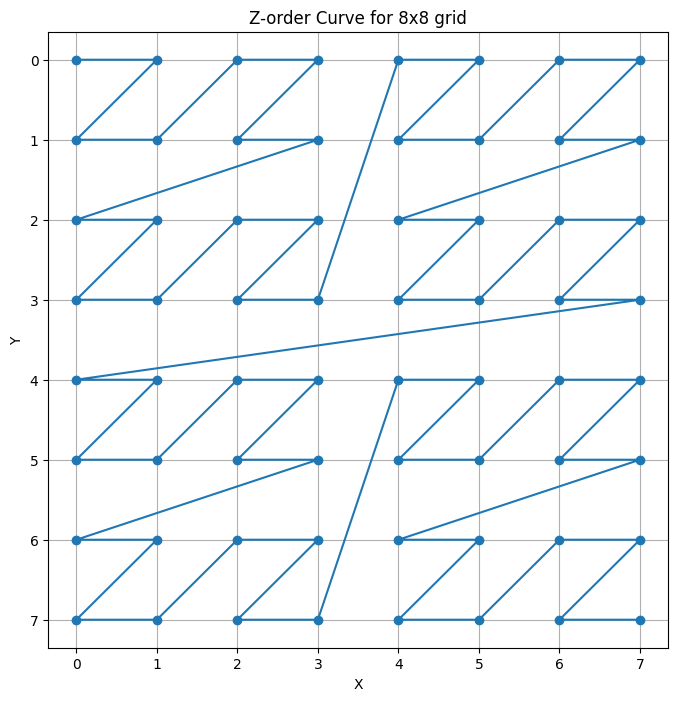

In [21]:
import matplotlib.pyplot as plt


def interleave_bits(x, y):
    """Interleave bits of x and y to produce Morton code (Z-order curve)."""
    z = 0
    for i in range(max(x.bit_length(), y.bit_length())):
        z |= ((x >> i) & 1) << (2 * i)
        z |= ((y >> i) & 1) << (2 * i + 1)
    return z


def z_order_curve(size):
    """Generate points in Z-order curve for a given size (2^n)."""
    points = []
    for x in range(size):
        for y in range(size):
            z = interleave_bits(x, y)
            points.append((z, x, y))
    points.sort()
    return [(x, y) for _, x, y in points]


def plot_z_order_curve(size):
    points = z_order_curve(size)
    x_coords, y_coords = zip(*points)

    plt.figure(figsize=(8, 8))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    plt.title(f'Z-order Curve for {size}x{size} grid')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.gca().invert_yaxis()  # Correct the orientation by inverting the y-axis
    plt.show()


# Example usage
plot_z_order_curve(8)


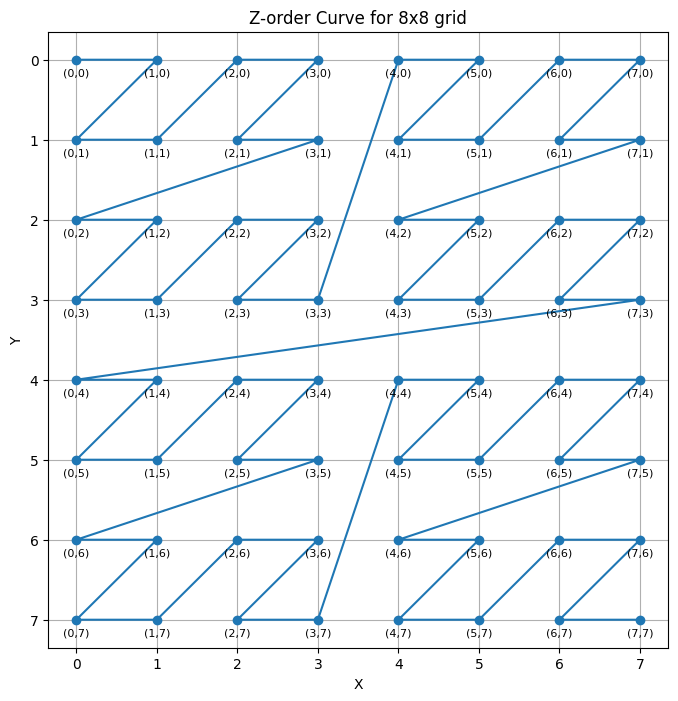

In [19]:
import matplotlib.pyplot as plt

def interleave_bits(x, y):
    z = 0
    for i in range(max(x.bit_length(), y.bit_length())):
        z |= ((x >> i) & 1) << (2 * i)
        z |= ((y >> i) & 1) << (2 * i + 1)
    return z

def z_order_curve(size):
    points = []
    for x in range(size):
        for y in range(size):
            z = interleave_bits(x, y)
            points.append((z, x, y))
    points.sort()
    return [(x, y) for _, x, y in points]

def plot_z_order_curve(size):
    points = z_order_curve(size)
    x_coords, y_coords = zip(*points)

    plt.figure(figsize=(8, 8))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    plt.title(f'Z-order Curve for {size}x{size} grid')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.gca().invert_yaxis()

    # Add text labels to each point with a vertical offset
    for i, (x, y) in enumerate(points):
        plt.text(x, y + 0.2, f'({x},{y})', fontsize=8, ha='center')

    plt.show()

plot_z_order_curve(8)


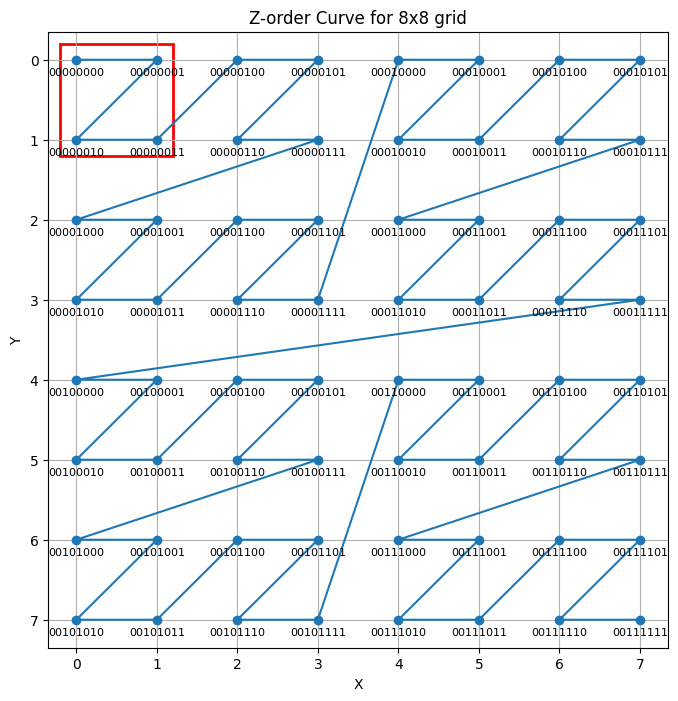

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def interleave_bits(x, y):
    z = 0
    for i in range(max(x.bit_length(), y.bit_length())):
        z |= ((x >> i) & 1) << (2 * i)
        z |= ((y >> i) & 1) << (2 * i + 1)
    return z

def z_order_curve(size):
    points = []
    for x in range(size):
        for y in range(size):
            z = interleave_bits(x, y)
            points.append((z, x, y))
    points.sort()
    return [(x, y) for _, x, y in points]

def plot_z_order_curve(size):
    points = z_order_curve(size)
    x_coords, y_coords = zip(*points)

    plt.figure(figsize=(8, 8))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    plt.title(f'Z-order Curve for {size}x{size} grid')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.gca().invert_yaxis()

    for i, (x, y) in enumerate(points):
        z = interleave_bits(x, y)
        plt.text(x, y + 0.2, f'{bin(z)[2:].zfill(2*size.bit_length())}', fontsize=8, ha='center')

    rect = patches.Rectangle((0 - 0.2, 0 - 0.2), 1.4, 1.4, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.show()

plot_z_order_curve(8)


In [74]:
spark.sql("select count(*) from zorder_data ").show()

+---------+
| count(1)|
+---------+
|500000000|
+---------+



In [93]:
spark.sql("DESCRIBE DETAIL zorder_data").show()


+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|e3794a9b-ed0e-4b3...|spark_catalog.zor...|       NULL|hdfs://192.168.0....|2024-06-14 18:28:...|2024-06-14 18:33:...|              []|      15|13975179718|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+------------------

In [77]:
!hdfs dfs -du -h hdfs://192.168.0.144:9000/datalake/zorder

13.0 G  39.0 G  hdfs://192.168.0.144:9000/datalake/zorder/zorder_data
13.0 G  39.0 G  hdfs://192.168.0.144:9000/datalake/zorder/zorder_data_raw


In [78]:
!hdfs dfs -count hdfs://192.168.0.144:9000/datalake/zorder

           5           34        27950385758 hdfs://192.168.0.144:9000/datalake/zorder


In [96]:
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_data")

delta_table_obj.optimize().executeZOrderBy("timestamp", "id")


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [108]:
    spark.catalog.clearCache()
query = """
SELECT avg(value)
FROM zorder_data
WHERE timestamp BETWEEN '2076-10-24 00:00:00' AND '2097-12-09 00:00:00'
  AND id BETWEEN 60146208810 AND 969803782;
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time without Z-Ordering: {execution_time_without_zorder} seconds")
    spark.catalog.clearCache()

Execution time without Z-Ordering: 0.2838006019592285 seconds


In [40]:
import json
from pyspark.sql import SparkSession
from pyspark.sql import Row



# Define the HDFS file path
file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized/_delta_log/00000000000000000002.json"

# Read the file from HDFS as a text file
df = spark.read.text(file_path)

# Initialize a list to collect the rows
rows = []

# Process each JSON line
for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        
        # Extracting min and max values for the required columns
        min_increasing_int1 = stats['minValues'].get('event_id')
        max_increasing_int1 = stats['maxValues'].get('event_id')

        
        # Append the values as a Row object
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1))

# Create a DataFrame from the list of rows
result_df = spark.createDataFrame(rows)

# Show the DataFrame
result_df.show(222)



+--------------------+-------------------+-------------------+
|                path|min_increasing_int1|max_increasing_int1|
+--------------------+-------------------+-------------------+
|part-00000-0a642b...|                  0|             999999|
+--------------------+-------------------+-------------------+



In [41]:

spark.sql("USE zorder")
spark.sql("drop table IF EXISTS  zorder_data_raw")
spark.sql("drop table IF EXISTS  zorder_data")
spark.sql("drop table IF EXISTS  	zorder_optimized")
spark.sql("drop table IF EXISTS  	zorder_raw")


DataFrame[]

In [4]:
spark.sql("use database zorder").show()


++
||
++
++



In [44]:
spark.sql("show tables").show()


+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|   zorder|zorder_optimized|      false|
|   zorder|      zorder_raw|      false|
+---------+----------------+-----------+



In [42]:
spark.sql("drop table test03").show()


++
||
++
++



In [37]:
spark.sql("drop table zorder_raw_small").show()
spark.sql("drop table zorder_optimized_small").show()

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `spark_catalog`.`default`.`zorder_raw_small` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.

In [12]:
spark.stop()

In [49]:

spark.sql("""
CREATE TABLE zorder_raw_large (
    date DATE,
    timestamp TIMESTAMP,
    value DOUBLE,
    country STRING,
    event_id INT,
    actor_id INT

)
USING delta;
""")

spark.sql("""
CREATE TABLE zorder_optimized_large (
    date DATE,
    timestamp TIMESTAMP,
    value DOUBLE,
    country STRING,
    event_id INT,
    actor_id INT

)
USING delta;
""")


24/06/19 21:14:15 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_raw_large` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/06/19 21:14:17 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_optimized_large` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


DataFrame[]

In [45]:

spark.sql("""
CREATE TABLE zorder_raw_small (
    date DATE,
    timestamp TIMESTAMP,
    value DOUBLE,
    country STRING,
    event_id INT,
    actor_id INT

)
USING delta;
""")

spark.sql("""
CREATE TABLE zorder_optimized_small (
    date DATE,
    timestamp TIMESTAMP,
    value DOUBLE,
    country STRING,
    event_id INT,
    actor_id INT

)
USING delta;
""")


24/06/19 20:24:05 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_raw_small` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/06/19 20:24:05 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/06/19 20:24:08 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_optimized_small` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


DataFrame[]

In [50]:

from datetime import datetime, timedelta
import itertools
import time
import os
import random
from pyspark.sql.functions import lit, rand, udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from delta.tables import DeltaTable

import random
import itertools
from datetime import datetime, timedelta
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, rand, udf, col, expr
from pyspark.sql.types import StringType



countries = ["USA", "Canada", "Mexico", "Brazil", "Argentina", "UK", "France", "Germany", "Italy", "Spain",
             "China", "Japan", "South Korea", "India", "Australia", "New Zealand", "South Africa", "Egypt", "Nigeria", "Kenya",
             "Russia", "Turkey", "Saudi Arabia", "Indonesia", "Thailand", "Malaysia", "Philippines", "Vietnam", "Singapore", "Pakistan",
             "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Maldives", "Mongolia", "Myanmar", "Laos", "Cambodia", "Brunei",
             "Israel", "Jordan", "Lebanon", "Syria", "Iraq", "Kuwait", "Bahrain", "Qatar", "UAE", "Oman",
             "Yemen", "Kazakhstan", "Uzbekistan", "Turkmenistan", "Kyrgyzstan", "Tajikistan", "Afghanistan", "Iran", "Armenia", "Azerbaijan",
             "Georgia", "Ukraine", "Belarus", "Poland", "Czech Republic", "Slovakia", "Hungary", "Romania", "Bulgaria", "Greece",
             "Portugal", "Netherlands", "Belgium", "Switzerland", "Austria", "Sweden", "Norway", "Denmark", "Finland", "Iceland",
             "Ireland", "Luxembourg", "Monaco", "Liechtenstein", "San Marino", "Andorra", "Vatican City", "Albania", "Bosnia and Herzegovina", "Croatia",
             "Montenegro", "Serbia", "Slovenia", "Macedonia", "Kosovo", "Estonia", "Latvia", "Lithuania"]

@udf(StringType())
def random_country():
    return random.choice(countries)


def generate_data(timestamp, nrows=2000000000):
    date = timestamp.date()
    return spark.range(nrows).select(
        lit(date).alias("date"),
        (lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        random_country().alias("country"),
        (rand() * 1000000).cast("int").alias("event_id"),
        (rand() * 10000).cast("int").alias("actor_id")
    )

hours_iter = (datetime(2024, 1, 1) + timedelta(hours=i) for i in itertools.count())

for timestamp in itertools.islice(hours_iter, 1):
    insert_data = generate_data(timestamp)
    insert_data.write.format("delta").mode("append").saveAsTable("zorder_raw_large")
    insert_data.write.format("delta").mode("append").saveAsTable("zorder_optimized_large")






In [128]:
spark.sql("describe detail  zorder_random ").show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|7656aa58-4015-4e3...|spark_catalog.zor...|       NULL|hdfs://192.168.0....|2024-06-14 19:56:...|2024-06-14 20:04:...|              []|       2| 2337724450|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+------------------

In [44]:
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized")

delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [47]:
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_small")

%time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


CPU times: user 447 ms, sys: 656 ms, total: 1.1 s
Wall time: 13min 12s


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [51]:
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_large")

%time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


CPU times: user 2.3 s, sys: 5.17 s, total: 7.47 s
Wall time: 1h 16min 23s


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [12]:
    spark.catalog.clearCache()
query = """
SELECT avg(value)
FROM zorder_raw
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time without Z-Ordering: {execution_time_without_zorder} seconds")
    spark.catalog.clearCache()

Execution time without Z-Ordering: 2.23071026802063 seconds


In [13]:
    spark.catalog.clearCache()
query = """
SELECT avg(value)
FROM zorder_optimized
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time with Z-Ordering: {execution_time_without_zorder} seconds")
    spark.catalog.clearCache()

Execution time without Z-Ordering: 1.5614140033721924 seconds


Average execution time without Z-Ordering: 18.301673412322998 seconds
Average execution time with Z-Ordering: 10.67960865497589 seconds


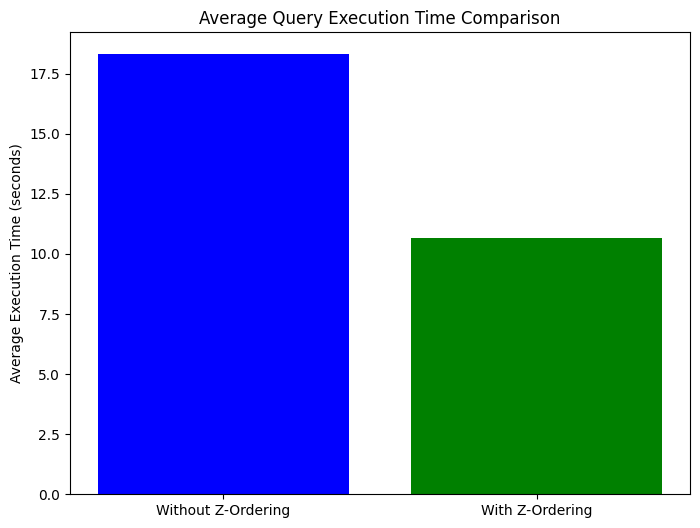

In [45]:
import time
import matplotlib.pyplot as plt

# Number of iterations
iterations = 10

# Lists to store execution times
execution_times_without_zorder = []
execution_times_with_zorder = []

# Queries
query_without_zorder = """
SELECT avg(value)
FROM zorder_raw
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

query_with_zorder = """
SELECT avg(value)
FROM zorder_optimized
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

# Execute queries multiple times and record execution times
for _ in range(iterations):
    # Clear cache and execute the first query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_without_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_without_zorder.append(end_time - start_time)

    # Clear cache and execute the second query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_with_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_with_zorder.append(end_time - start_time)

# Calculate average execution times
avg_execution_time_without_zorder = sum(execution_times_without_zorder) / iterations
avg_execution_time_with_zorder = sum(execution_times_with_zorder) / iterations

print(f"Average execution time without Z-Ordering: {avg_execution_time_without_zorder} seconds")
print(f"Average execution time with Z-Ordering: {avg_execution_time_with_zorder} seconds")

# Plot the average execution times
labels = ['Without Z-Ordering', 'With Z-Ordering']
avg_times = [avg_execution_time_without_zorder, avg_execution_time_with_zorder]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, avg_times, color=['blue', 'green'])
ax.set_ylabel('Average Execution Time (seconds)')
ax.set_title('Average Query Execution Time Comparison')
plt.show()


Average execution time without Z-Ordering: 15.396576881408691 seconds
Average execution time with Z-Ordering: 14.027205872535706 seconds


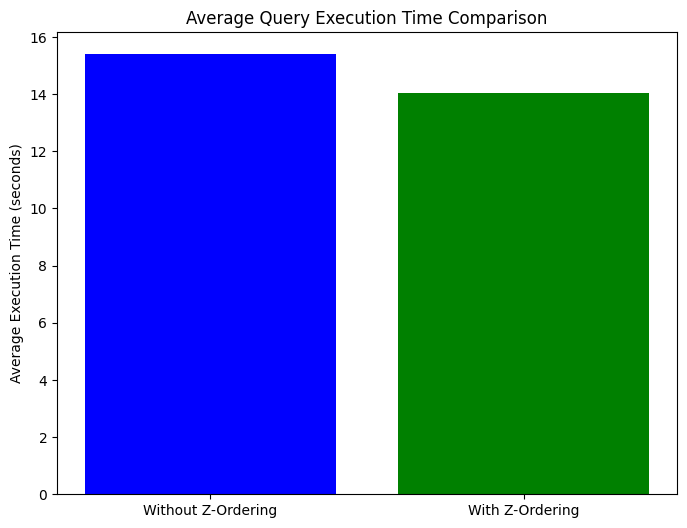

In [48]:
import time
import matplotlib.pyplot as plt

# Number of iterations
iterations = 10

# Lists to store execution times
execution_times_without_zorder = []
execution_times_with_zorder = []

# Queries
query_without_zorder = """
SELECT avg(value)
FROM zorder_raw_small
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

query_with_zorder = """
SELECT avg(value)
FROM zorder_optimized_small
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

# Execute queries multiple times and record execution times
for _ in range(iterations):
    # Clear cache and execute the first query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_without_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_without_zorder.append(end_time - start_time)

    # Clear cache and execute the second query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_with_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_with_zorder.append(end_time - start_time)

# Calculate average execution times
avg_execution_time_without_zorder = sum(execution_times_without_zorder) / iterations
avg_execution_time_with_zorder = sum(execution_times_with_zorder) / iterations

print(f"Average execution time without Z-Ordering: {avg_execution_time_without_zorder} seconds")
print(f"Average execution time with Z-Ordering: {avg_execution_time_with_zorder} seconds")

# Plot the average execution times
labels = ['Without Z-Ordering', 'With Z-Ordering']
avg_times = [avg_execution_time_without_zorder, avg_execution_time_with_zorder]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, avg_times, color=['blue', 'green'])
ax.set_ylabel('Average Execution Time (seconds)')
ax.set_title('Average Query Execution Time Comparison')
plt.show()


24/06/20 06:57:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Average execution time without Z-Ordering: 44.19879837036133 seconds
Average execution time with Z-Ordering: 20.406039929389955 seconds


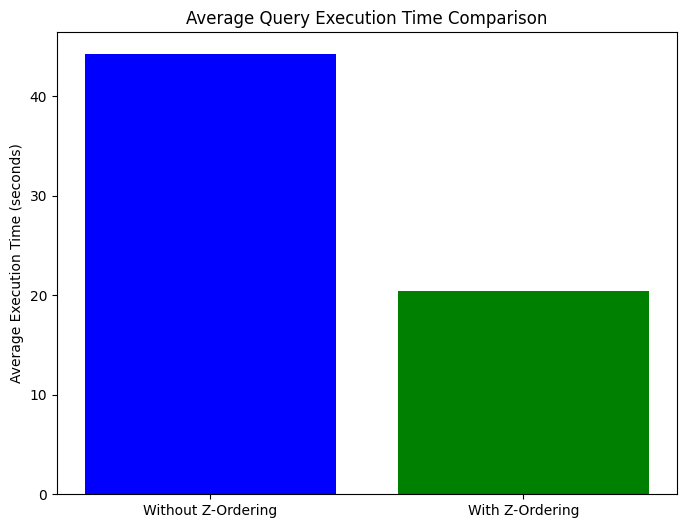

In [5]:
import time
import matplotlib.pyplot as plt

# Number of iterations
iterations = 10

# Lists to store execution times
execution_times_without_zorder = []
execution_times_with_zorder = []

# Queries
query_without_zorder = """
SELECT avg(value)
FROM zorder_raw_large
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

query_with_zorder = """
SELECT avg(value)
FROM zorder_optimized_large
WHERE event_id BETWEEN 459999 AND 999999
  AND actor_id BETWEEN 4500 AND 9999;
"""

# Execute queries multiple times and record execution times
for _ in range(iterations):
    # Clear cache and execute the first query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_without_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_without_zorder.append(end_time - start_time)

    # Clear cache and execute the second query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_with_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_with_zorder.append(end_time - start_time)

# Calculate average execution times
avg_execution_time_without_zorder = sum(execution_times_without_zorder) / iterations
avg_execution_time_with_zorder = sum(execution_times_with_zorder) / iterations

print(f"Average execution time without Z-Ordering: {avg_execution_time_without_zorder} seconds")
print(f"Average execution time with Z-Ordering: {avg_execution_time_with_zorder} seconds")

# Plot the average execution times
labels = ['Without Z-Ordering', 'With Z-Ordering']
avg_times = [avg_execution_time_without_zorder, avg_execution_time_with_zorder]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, avg_times, color=['blue', 'green'])
ax.set_ylabel('Average Execution Time (seconds)')
ax.set_title('Average Query Execution Time Comparison')
plt.show()


24/06/15 09:29:06 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


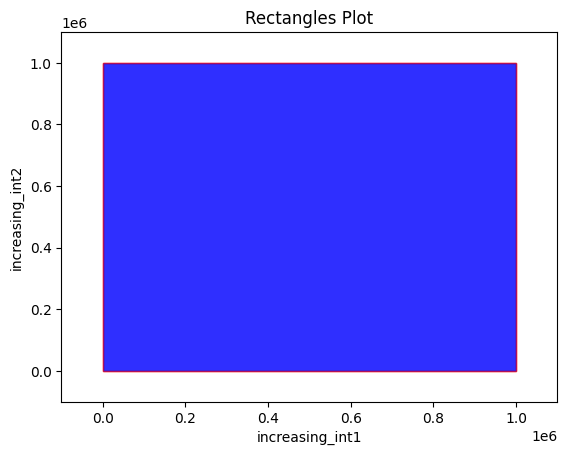

In [163]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read Delta Log from HDFS") \
    .getOrCreate()

# Define the HDFS file path
file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_random_raw/_delta_log/00000000000000000001.json"

# Read the file from HDFS as a text file
df = spark.read.text(file_path)
#df.show(truncate=False)

# Initialize a list to collect the rows
rows = []

# Process each JSON line
for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['random_int1']
        max_increasing_int1 = stats['maxValues']['random_int1']
        min_increasing_int2 = stats['minValues']['random_int2']
        max_increasing_int2 = stats['maxValues']['random_int2']
        
        # Append the values as a Row object
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

# Create a DataFrame from the list of rows
result_df = spark.createDataFrame(rows)

# Collect the DataFrame rows to draw rectangles
rectangles = result_df.collect()

# Create a figure and an axes
fig, ax = plt.subplots()

# Draw rectangles for each row with transparency (alpha)
for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    # Calculate width and height
    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    # Create a rectangle with transparency
    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

# Set the limits of the plot to fit all rectangles with some padding
all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

# Set labels
ax.set_xlabel('increasing_int1')
ax.set_ylabel('increasing_int2')
ax.set_title('Rectangles Plot')

# Show the plot
plt.show()


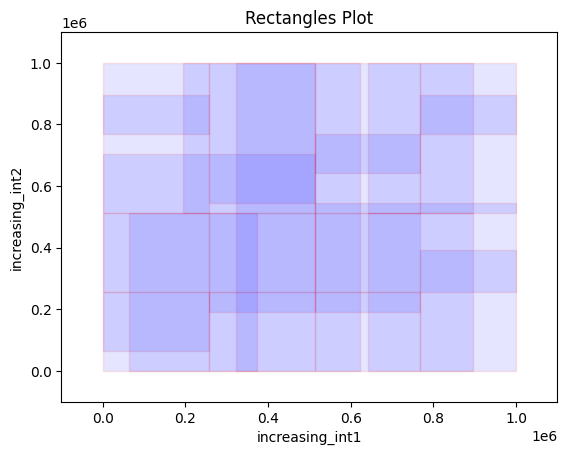

In [132]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read Delta Log from HDFS") \
    .getOrCreate()

# Define the HDFS file path
file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_random/_delta_log/00000000000000000002.json"

# Read the file from HDFS as a text file
df = spark.read.text(file_path)
#df.show(truncate=False)

# Initialize a list to collect the rows
rows = []

# Process each JSON line
for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['random_int1']
        max_increasing_int1 = stats['maxValues']['random_int1']
        min_increasing_int2 = stats['minValues']['random_int2']
        max_increasing_int2 = stats['maxValues']['random_int2']
        
        # Append the values as a Row object
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

# Create a DataFrame from the list of rows
result_df = spark.createDataFrame(rows)

# Collect the DataFrame rows to draw rectangles
rectangles = result_df.collect()

# Create a figure and an axes
fig, ax = plt.subplots()

# Draw rectangles for each row with transparency (alpha)
for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    # Calculate width and height
    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    # Create a rectangle with transparency
    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

# Set the limits of the plot to fit all rectangles with some padding
all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

# Set labels
ax.set_xlabel('increasing_int1')
ax.set_ylabel('increasing_int2')
ax.set_title('Rectangles Plot')

plt.savefig('zorder_monotonic.png', dpi=500)
# Show the plot
plt.show()



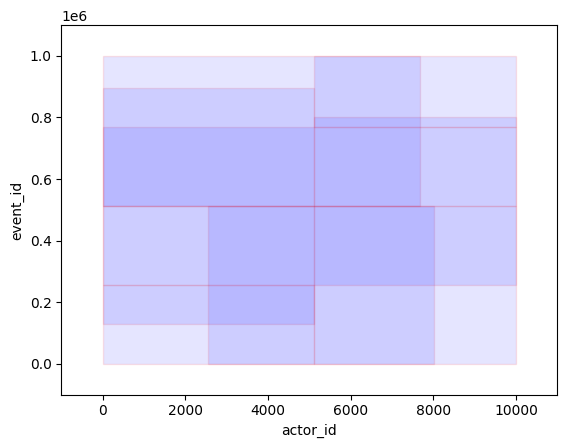

In [33]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read Delta Log from HDFS") \
    .getOrCreate()

# Define the HDFS file path
file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_small/_delta_log/00000000000000000002.json"

# Read the file from HDFS as a text file
df = spark.read.text(file_path)
#df.show(truncate=False)

# Initialize a list to collect the rows
rows = []

# Process each JSON line
for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['actor_id']
        max_increasing_int1 = stats['maxValues']['actor_id']
        min_increasing_int2 = stats['minValues']['event_id']
        max_increasing_int2 = stats['maxValues']['event_id']
        
        # Append the values as a Row object
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

# Create a DataFrame from the list of rows
result_df = spark.createDataFrame(rows)

# Collect the DataFrame rows to draw rectangles
rectangles = result_df.collect()

# Create a figure and an axes
fig, ax = plt.subplots()

# Draw rectangles for each row with transparency (alpha)
for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    # Calculate width and height
    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    # Create a rectangle with transparency
    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

# Set the limits of the plot to fit all rectangles with some padding
all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

# Set labels
ax.set_xlabel('actor_id')
ax.set_ylabel('event_id')
#ax.set_title('Rectangles Plot')

plt.savefig('zorder_random.png', dpi=500)
# Show the plot
plt.show()



In [ ]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Read Delta Log from HDFS") \
    .getOrCreate()

# Define the HDFS file path
file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_random/_delta_log/00000000000000000002.json"

# Read the file from HDFS as a text file
df = spark.read.text(file_path)
#df.show(truncate=False)

# Initialize a list to collect the rows
rows = []

# Process each JSON line
for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['random_int1']
        max_increasing_int1 = stats['maxValues']['random_int1']
        min_increasing_int2 = stats['minValues']['random_int2']
        max_increasing_int2 = stats['maxValues']['random_int2']
        
        # Append the values as a Row object
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

# Create a DataFrame from the list of rows
result_df = spark.createDataFrame(rows)

# Collect the DataFrame rows to draw rectangles
rectangles = result_df.collect()

# Create a figure and an axes
fig, ax = plt.subplots()

# Draw rectangles for each row with transparency (alpha)
for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    # Calculate width and height
    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    # Create a rectangle with transparency
    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

# Set the limits of the plot to fit all rectangles with some padding
all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

# Set labels
ax.set_xlabel('increasing_int1')
ax.set_ylabel('increasing_int2')
ax.set_title('Rectangles Plot')

plt.savefig(dpi=300)
# Show the plot
plt.show()



In [11]:
spark.sql("select max(actor_id), min(actor_id), max(event_id), min(event_id) from zorder_optimized").show()


+-------------+-------------+-------------+-------------+
|max(actor_id)|min(actor_id)|max(event_id)|min(event_id)|
+-------------+-------------+-------------+-------------+
|         9999|            0|       999999|            0|
+-------------+-------------+-------------+-------------+



In [169]:
spark.stop()

In [32]:
spark.sql("use database github").show(truncate=False)


++
||
++
++



In [3]:
spark.sql("show tables").show(truncate=False)


+---------+-------------------------------------+-----------+
|namespace|tableName                            |isTemporary|
+---------+-------------------------------------+-----------+
|github   |githubarchive_202307                 |false      |
|github   |githubarchive_202307_liquidclustering|false      |
|github   |githubarchive_202307_partition       |false      |
|github   |githubarchive_202307_zorder          |false      |
|github   |githubarchive_202308                 |false      |
|github   |githubarchive_202309                 |false      |
|github   |githubarchive_202310                 |false      |
+---------+-------------------------------------+-----------+



24/06/16 11:18:54 ERROR TaskSchedulerImpl: Lost executor 2 on 192.168.0.150: worker lost: Not receiving heartbeat for 60 seconds


In [27]:
spark.sql("describe detail  githubarchive_202307_zorder").show(truncate=False)


+------+------------------------------------+------------------------------------------------+-----------+--------------------------------------------------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                                            |description|location                                                                              |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+------------------------------------------------+-----------+--------------------------------------------------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------

In [26]:
spark.sql("describe detail  githubarchive_202307_zorder").show(truncate=False)


+------+------------------------------------+------------------------------------------------+-----------+--------------------------------------------------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                                            |description|location                                                                              |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+------------------------------------------------+-----------+--------------------------------------------------------------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------

In [6]:
spark.sql("select max(repo_id), min(repo_id), day from githubarchive_202307_zorder group by day").show(truncate=False)


+------------+------------+--------+
|max(repo_id)|min(repo_id)|day     |
+------------+------------+--------+
|661147393   |68          |20230701|
|668060936   |363         |20230718|
|662346327   |28          |20230704|
|663268828   |144         |20230706|
|661903519   |28          |20230703|
|662808743   |144         |20230705|
|667620973   |27          |20230717|
|666193168   |1           |20230713|
|661469071   |507         |20230702|
|665314102   |42          |20230711|
|664868092   |322         |20230710|
|664108737   |1           |20230708|
|668927731   |507         |20230720|
|667191227   |2376        |20230716|
|664423987   |426         |20230709|
|666892201   |130         |20230715|
|663715712   |1           |20230707|
|668488852   |28          |20230719|
|665756744   |68          |20230712|
|666593464   |1           |20230714|
+------------+------------+--------+
only showing top 20 rows



In [23]:
import time

spark.catalog.clearCache()

query = """
SELECT avg(day)
FROM githubarchive_202307
WHERE day BETWEEN 20230720 AND 20230729
  AND repo_id BETWEEN 67191227 AND 667191227;
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time with Z-Ordering: {execution_time_without_zorder} seconds")
spark.catalog.clearCache()

Execution time with Z-Ordering: 26.42607831954956 seconds


In [24]:
spark.catalog.clearCache()
query = """
SELECT avg(day)
FROM githubarchive_202307_zorder
WHERE day BETWEEN 20230720 AND 20230729
  AND repo_id BETWEEN 67191227 AND 667191227;
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time with Z-Ordering: {execution_time_without_zorder} seconds")
spark.catalog.clearCache()

Execution time with Z-Ordering: 14.141484498977661 seconds


In [16]:
import time

spark.catalog.clearCache()

query = """
select day, count(*) 
from githubarchive_202307 
group by day
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time with Z-Ordering: {execution_time_without_zorder} seconds")
spark.catalog.clearCache()

Execution time with Z-Ordering: 7.509631395339966 seconds


In [17]:
spark.catalog.clearCache()
query = """
select day, count(*) 
from githubarchive_202307_zorder 
group by day
"""

# Measure execution time
start_time = time.time()
spark.sql(query).count()  # Using count() to force the query to execute
end_time = time.time()

execution_time_without_zorder = end_time - start_time
print(f"Execution time with Z-Ordering: {execution_time_without_zorder} seconds")
spark.catalog.clearCache()

Execution time with Z-Ordering: 7.6647632122039795 seconds


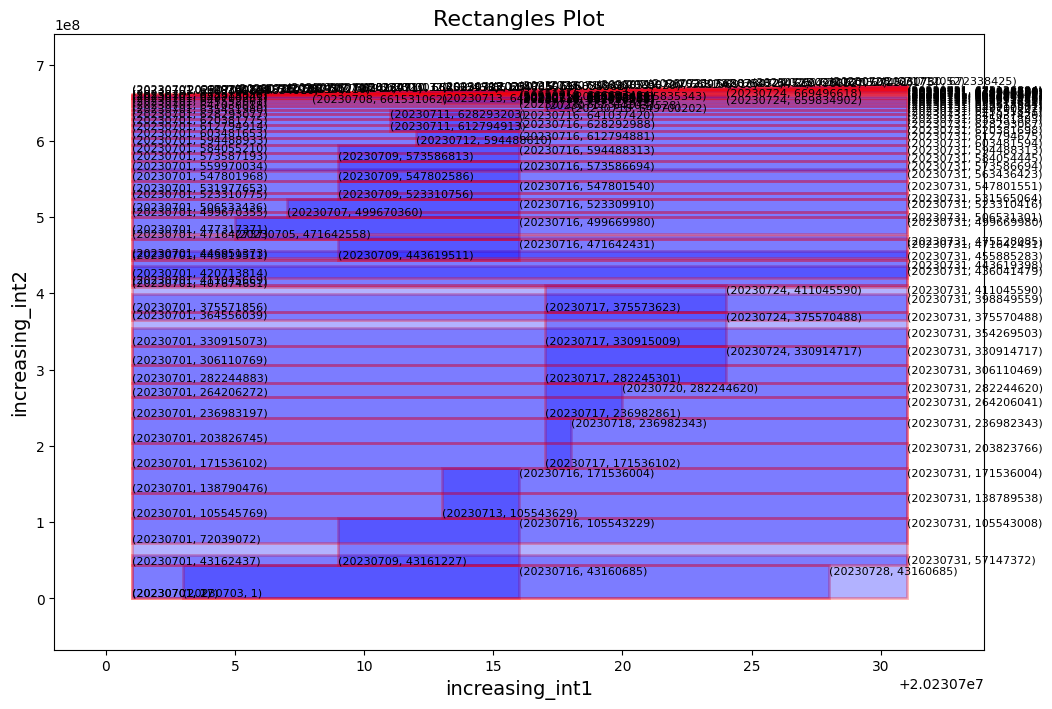

24/06/16 11:34:19 WARN TransportChannelHandler: Exception in connection from /192.168.0.150:53264
java.io.IOException: No route to host
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:724)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:6

In [13]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row



# Define the HDFS file path
file_path = "hdfs://192.168.0.144:9000/datalake/githubarchive/deltalake/githubarchive_202307_zorder/_delta_log/00000000000000000002.json"

# Read the file from HDFS as a text file
df = spark.read.text(file_path)
#df.show(truncate=False)

# Initialize a list to collect the rows
rows = []

# Process each JSON line
for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['day']
        max_increasing_int1 = stats['maxValues']['day']
        min_increasing_int2 = stats['minValues']['repo_id']
        max_increasing_int2 = stats['maxValues']['repo_id']
        
        # Append the values as a Row object
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

# Create a DataFrame from the list of rows
result_df = spark.createDataFrame(rows)

# Collect the DataFrame rows to draw rectangles
rectangles = result_df.collect()

# Create a figure and an axes with larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Draw rectangles for each row with transparency (alpha)
for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    # Calculate width and height
    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    # Create a rectangle with transparency
    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=2, edgecolor='r', facecolor='blue', alpha=0.3)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Annotate with coordinates
    ax.text(bottom_left_x, bottom_left_y, f'({bottom_left_x}, {bottom_left_y})', fontsize=8, verticalalignment='bottom', color='black')
    ax.text(top_right_x, top_right_y, f'({top_right_x}, {top_right_y})', fontsize=8, verticalalignment='top', color='black')

# Set the limits of the plot to fit all rectangles with some padding
all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

# Set labels
ax.set_xlabel('increasing_int1', fontsize=14)
ax.set_ylabel('increasing_int2', fontsize=14)
ax.set_title('Rectangles Plot', fontsize=16)

# Show the plot
plt.show()


Average execution time without Z-Ordering: 16.339327502250672 seconds
Average execution time with Z-Ordering: 11.80211501121521 seconds


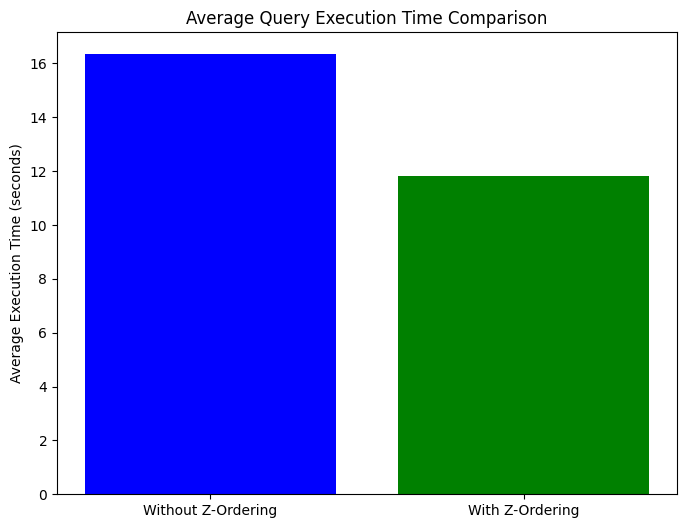

In [33]:
import time
import matplotlib.pyplot as plt

iterations = 10

execution_times_without_zorder = []
execution_times_with_zorder = []

query_without_zorder = """
SELECT avg(day)
FROM githubarchive_202307
WHERE day BETWEEN 20230720 AND 20230729
  AND repo_id BETWEEN 67191227 AND 667191227;
"""

query_with_zorder = """
SELECT avg(day)
FROM githubarchive_202307_zorder
WHERE day BETWEEN 20230720 AND 20230729
  AND repo_id BETWEEN 67191227 AND 667191227;
"""

for _ in range(iterations):
    # Clear cache and execute the first query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_without_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_without_zorder.append(end_time - start_time)

    # Clear cache and execute the second query
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query_with_zorder).count()  # Using count() to force the query to execute
    end_time = time.time()
    execution_times_with_zorder.append(end_time - start_time)

avg_execution_time_without_zorder = sum(execution_times_without_zorder) / iterations
avg_execution_time_with_zorder = sum(execution_times_with_zorder) / iterations

print(f"Average execution time without Z-Ordering: {avg_execution_time_without_zorder} seconds")
print(f"Average execution time with Z-Ordering: {avg_execution_time_with_zorder} seconds")

labels = ['Without Z-Ordering', 'With Z-Ordering']
avg_times = [avg_execution_time_without_zorder, avg_execution_time_with_zorder]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, avg_times, color=['blue', 'green'])
ax.set_ylabel('Average Execution Time (seconds)')
ax.set_title('Average Query Execution Time Comparison')
plt.show()


In [16]:
!hdfs dfs -du -s -h /datalake/zorder/zorder_optimized
!hdfs dfs -du -s -h /datalake/zorder/zorder_optimized_large
!hdfs dfs -du -s -h /datalake/zorder/zorder_optimized_small


20.0 G  59.9 G  /datalake/zorder/zorder_optimized
40.0 G  120.0 G  /datalake/zorder/zorder_optimized_large
10.0 G  29.9 G  /datalake/zorder/zorder_optimized_small


In [ ]:
+---------+----------------------+-----------+
|zorder   |zorder_optimized      |false      |
|zorder   |zorder_optimized_large|false      |
|zorder   |zorder_optimized_small|false      |
|zorder   |zorder_raw            |false      |
|zorder   |zorder_raw_large      |false      |
|zorder   |zorder_raw_small   

In [17]:
# Queries
query_without_zorder = """
SELECT count(*) as zorder_optimized
FROM zorder_optimized
"""

query_with_zorder = """
SELECT count(*) as zorder_optimized_small
FROM zorder_optimized_small
"""

query_with_zorder1 = """
SELECT count(*) as zorder_optimized_large
FROM zorder_optimized_large
"""


spark.sql(query_without_zorder).show()  # Using count() to force the query to execute
spark.sql(query_with_zorder).show()  # Using count() to force the query to execute
spark.sql(query_with_zorder1).show()  # Using count() to force the query to execute


+----------------+
|zorder_optimized|
+----------------+
|      1000000000|
+----------------+

+----------------------+
|zorder_optimized_small|
+----------------------+
|             500000000|
+----------------------+

+----------------------+
|zorder_optimized_large|
+----------------------+
|            2000000000|
+----------------------+



In [7]:
spark.sql("show tables").show(truncate=False)  # Using count() to force the query to execute


+---------+----------------------+-----------+
|namespace|tableName             |isTemporary|
+---------+----------------------+-----------+
|zorder   |zorder_optimized      |false      |
|zorder   |zorder_optimized_large|false      |
|zorder   |zorder_optimized_small|false      |
|zorder   |zorder_raw            |false      |
|zorder   |zorder_raw_large      |false      |
|zorder   |zorder_raw_small      |false      |
+---------+----------------------+-----------+



In [12]:
from delta.tables import DeltaTable

spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
delta_table_obj = DeltaTable.forPath(spark, 'hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized')
%time delta_table_obj.vacuum(0)

Deleted 20 files and directories in a total of 1 directories.
CPU times: user 55.5 ms, sys: 61.4 ms, total: 117 ms
Wall time: 22.4 s


DataFrame[]

In [13]:
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
delta_table_obj = DeltaTable.forPath(spark, 'hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_large')
%time delta_table_obj.vacuum(0)

Deleted 20 files and directories in a total of 1 directories.
CPU times: user 35.6 ms, sys: 56.3 ms, total: 92 ms
Wall time: 18.3 s


DataFrame[]

In [14]:
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
delta_table_obj = DeltaTable.forPath(spark, 'hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_small')
%time delta_table_obj.vacuum(0)

Deleted 20 files and directories in a total of 1 directories.
CPU times: user 55.4 ms, sys: 49.3 ms, total: 105 ms
Wall time: 18.1 s


DataFrame[]

In [ ]:
nr rows 19093150494

+----------------+
|zorder_optimized|
+----------------+
|      1000000000|
+----------------+

+----------------------+
|zorder_optimized_small|
+----------------------+
|             500000000|
+----------------------+

+----------------------+
|zorder_optimized_large|
+----------------------+
|            2000000000|
+----------------------+


size_before_compaction  431.6 G  1.3 T
files_count_before_compaction 112217
query_time_before_compaction 47min 40s, 40min 02s
Average execution time without Z-Ordering: 44.19879837036133 seconds
Average execution time with Z-Ordering: 20.406039929389955 seconds

size_after_compaction 
files_count_after_compaction  429
query_time_after_compaction  17min 56s 19 3


compaction time  Wall time: 5h 11min 49s




Wall time: 13min 12s


Wall time: 33min 12s


Wall time: 1h 16min 23s




nr rows 54750
size of files before compaction 83.9 G  251.7 G
size of files few files  after compaction 166.9 G  500.6 G 


size_before_compaction  83.9 G  251.7 G
files_count_before_compaction 54750
query_time_before_compaction 16min 4s  19min 40s  964 1140 


size_after_compaction 166.9 G 
files_count_after_compaction  83
query_time_after_compaction 7min 36s   456


compaction time 42min 6s  2526 






nr rows 27375




size_before_compaction  41.7 G  125.1 G 
files_count_before_compaction 27375
query_time_before_compaction  9min 24s 7min 54s   564 474 
Average execution time without Z-Ordering: 18.301673412322998 seconds
Average execution time with Z-Ordering: 10.67960865497589 seconds

size_after_compaction   83.2 G  249.5 G 
files_count_after_compaction   42
query_time_after_compaction 3min 45s 3min 47s   225 227


compaction time  23min 32s    1412



20.0 G  59.9 G  /datalake/zorder/zorder_optimized
40.0 G  120.0 G  /datalake/zorder/zorder_optimized_large
10.0 G  29.9 G  /datalake/zorder/zorder_optimized_small


nr rows 912




size_before_compaction 20.8 G  62.3 G   
files_count_before_compaction 13680
query_time_before_compaction   6min 16s   3min 24s  376  204  
Average execution time without Z-Ordering: 15.396576881408691 seconds
Average execution time with Z-Ordering: 14.027205872535706 seconds

size_after_compaction  41.5 G  124.5 G 
files_count_after_compaction  21
query_time_after_compaction  1min 48s   108 


compaction time  Wall time: 12min 25s  745 

In [11]:
spark.sql("""
drop TABLE zorder_monotonic 
""")

DataFrame[]

In [12]:
spark.sql("""
CREATE TABLE zorder_monotonic (
    date DATE,
    timestamp TIMESTAMP,
    value DOUBLE,
    country STRING,
    event_id LONG,
    actor_id LONG

)
USING delta;
""")

24/07/16 11:19:01 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_monotonic` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


DataFrame[]

In [13]:

from datetime import datetime, timedelta
import itertools
import time
import os
import random
from pyspark.sql.functions import lit, rand, udf
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from delta.tables import DeltaTable

import random
import itertools
from datetime import datetime, timedelta
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, rand, udf, col, expr
from pyspark.sql.types import StringType



countries = ["USA", "Canada", "Mexico", "Brazil", "Argentina", "UK", "France", "Germany", "Italy", "Spain",
             "China", "Japan", "South Korea", "India", "Australia", "New Zealand", "South Africa", "Egypt", "Nigeria", "Kenya",
             "Russia", "Turkey", "Saudi Arabia", "Indonesia", "Thailand", "Malaysia", "Philippines", "Vietnam", "Singapore", "Pakistan",
             "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Maldives", "Mongolia", "Myanmar", "Laos", "Cambodia", "Brunei",
             "Israel", "Jordan", "Lebanon", "Syria", "Iraq", "Kuwait", "Bahrain", "Qatar", "UAE", "Oman",
             "Yemen", "Kazakhstan", "Uzbekistan", "Turkmenistan", "Kyrgyzstan", "Tajikistan", "Afghanistan", "Iran", "Armenia", "Azerbaijan",
             "Georgia", "Ukraine", "Belarus", "Poland", "Czech Republic", "Slovakia", "Hungary", "Romania", "Bulgaria", "Greece",
             "Portugal", "Netherlands", "Belgium", "Switzerland", "Austria", "Sweden", "Norway", "Denmark", "Finland", "Iceland",
             "Ireland", "Luxembourg", "Monaco", "Liechtenstein", "San Marino", "Andorra", "Vatican City", "Albania", "Bosnia and Herzegovina", "Croatia",
             "Montenegro", "Serbia", "Slovenia", "Macedonia", "Kosovo", "Estonia", "Latvia", "Lithuania"]

@udf(StringType())
def random_country():
    return random.choice(countries)


def generate_data(timestamp, nrows=300000000):
    date = timestamp.date()
    
    # Create a DataFrame with `nrows` rows using spark.range
    base_df = spark.range(nrows)
    
    return base_df.select(
        lit(date).alias("date"),
        (lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        random_country().alias("country"),
        (col("id") + 1).alias("event_id"),  # Ensure event_id starts from 1
        (col("id") + 1).alias("actor_id")   # Ensure actor_id starts from 1
    )

hours_iter = (datetime(2024, 1, 1) + timedelta(hours=i) for i in itertools.count())

for timestamp in itertools.islice(hours_iter, 1):
    insert_data = generate_data(timestamp)
    insert_data.write.format("delta").mode("append").saveAsTable("zorder_monotonic")






24/07/16 11:19:18 WARN TaskSetManager: Lost task 7.0 in stage 47.0 (TID 927) (192.168.0.149 executor 4): org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to hdfs://192.168.0.144:9000/datalake/zorder/zorder_monotonic.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:774)
	at org.apache.spark.sql.delta.files.DeltaFileFormatWriter$.executeTask(DeltaFileFormatWriter.scala:447)
	at org.apache.spark.sql.delta.files.DeltaFileFormatWriter$.$anonfun$executeWrite$2(DeltaFileFormatWriter.scala:274)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkE

In [14]:
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_monotonic")

delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

+--------------------+-------------------+-------------------+-------------------+-------------------+
|                path|min_increasing_int1|max_increasing_int1|min_increasing_int2|max_increasing_int2|
+--------------------+-------------------+-------------------+-------------------+-------------------+
|part-00000-3db53b...|                  1|           51048444|                  1|           51048444|
|part-00001-9c3944...|           50763053|           99905801|           50763053|           99905801|
|part-00002-a5951f...|           99670151|          148429046|           99670151|          148429046|
|part-00003-8753a2...|          148210156|          198300745|          148210156|          198300745|
|part-00004-c4f7d6...|          198259554|          249887875|          198259554|          249887875|
|part-00005-e9b547...|          249630218|          300000000|          249630218|          300000000|
+--------------------+-------------------+-------------------+-----------

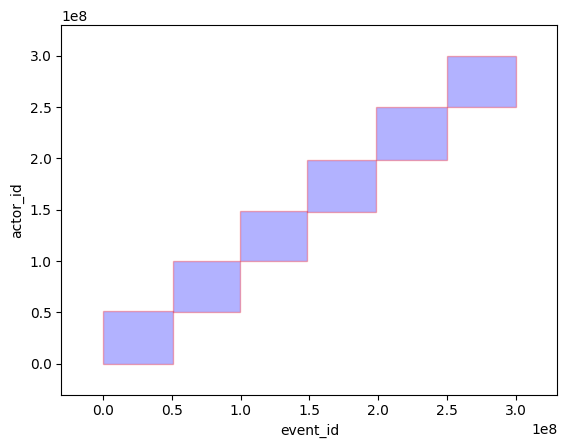

In [29]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row



file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_monotonic/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['event_id']
        max_increasing_int1 = stats['maxValues']['event_id']
        min_increasing_int2 = stats['minValues']['actor_id']
        max_increasing_int2 = stats['maxValues']['actor_id']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()
result_df.show()
fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='red', facecolor='blue', alpha=0.3)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('event_id')
ax.set_ylabel('actor_id')
#ax.set_title('Z-Order monotonically increasing attributes')

plt.savefig('zorder_monotonic.png', dpi=500)
plt.show()



In [4]:
spark.sql("""
show tables
""").show(truncate=False)

+---------+----------------------+-----------+
|namespace|tableName             |isTemporary|
+---------+----------------------+-----------+
|zorder   |zorder_monotonic      |false      |
|zorder   |zorder_optimized      |false      |
|zorder   |zorder_optimized_large|false      |
|zorder   |zorder_optimized_small|false      |
|zorder   |zorder_raw            |false      |
|zorder   |zorder_raw_large      |false      |
|zorder   |zorder_raw_small      |false      |
+---------+----------------------+-----------+



In [20]:

spark.sql("""
drop table zorder_monotonic            
""").show(truncate=False)


++
||
++
++



In [5]:
spark.sql("""
select * from zorder_optimized      
""").show()

24/07/16 14:19:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------------------+-------------------+------------+--------+--------+
|      date|          timestamp|              value|     country|event_id|actor_id|
+----------+-------------------+-------------------+------------+--------+--------+
|2024-01-01|2038-04-05 08:00:06|0.33804180084045965|       Syria|   94884|    3771|
|2024-01-01|2038-04-05 08:00:38| 0.2309320647270373|       Yemen|   98928|    3459|
|2024-01-01|2038-04-05 08:00:44| 0.4499934724297775|   Argentina|   94942|    4497|
|2024-01-01|2038-04-05 08:00:53| 0.1555651531254616|     Vietnam|  217310|    2051|
|2024-01-01|2038-04-05 08:00:59| 0.5336593235076518|     Austria|   65500|    4142|
|2024-01-01|2038-04-05 08:02:00| 0.6115996285836658|     Finland|   39492|    3443|
|2024-01-01|2038-04-05 08:02:06|  0.906183879896736|    Cambodia|  192971|    2060|
|2024-01-01|2038-04-05 08:02:32| 0.3681708705937926|      Monaco|  157501|    2657|
|2024-01-01|2038-04-05 08:03:06|0.37543457393020563|Saudi Arabia|  144607|  

Table: zorder_monotonic, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/zorder_monotonic, Size: 14892350634 bytes, Number of Files: 6, Partition Columns: [], Subdirectories: 30, Number of Rows: 300000000
Table: zorder_optimized, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized, Size: 21424683039 bytes, Number of Files: 19, Partition Columns: [], Subdirectories: 24, Number of Rows: 1000000000
Table: zorder_optimized_large, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_large, Size: 42933153009 bytes, Number of Files: 38, Partition Columns: [], Subdirectories: 43, Number of Rows: 2000000000
Table: zorder_optimized_small, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_small, Size: 10699722762 bytes, Number of Files: 9, Partition Columns: [], Subdirectories: 14, Number of Rows: 500000000
Table: zorder_raw, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/zorder_raw, Size: 20921078756 bytes

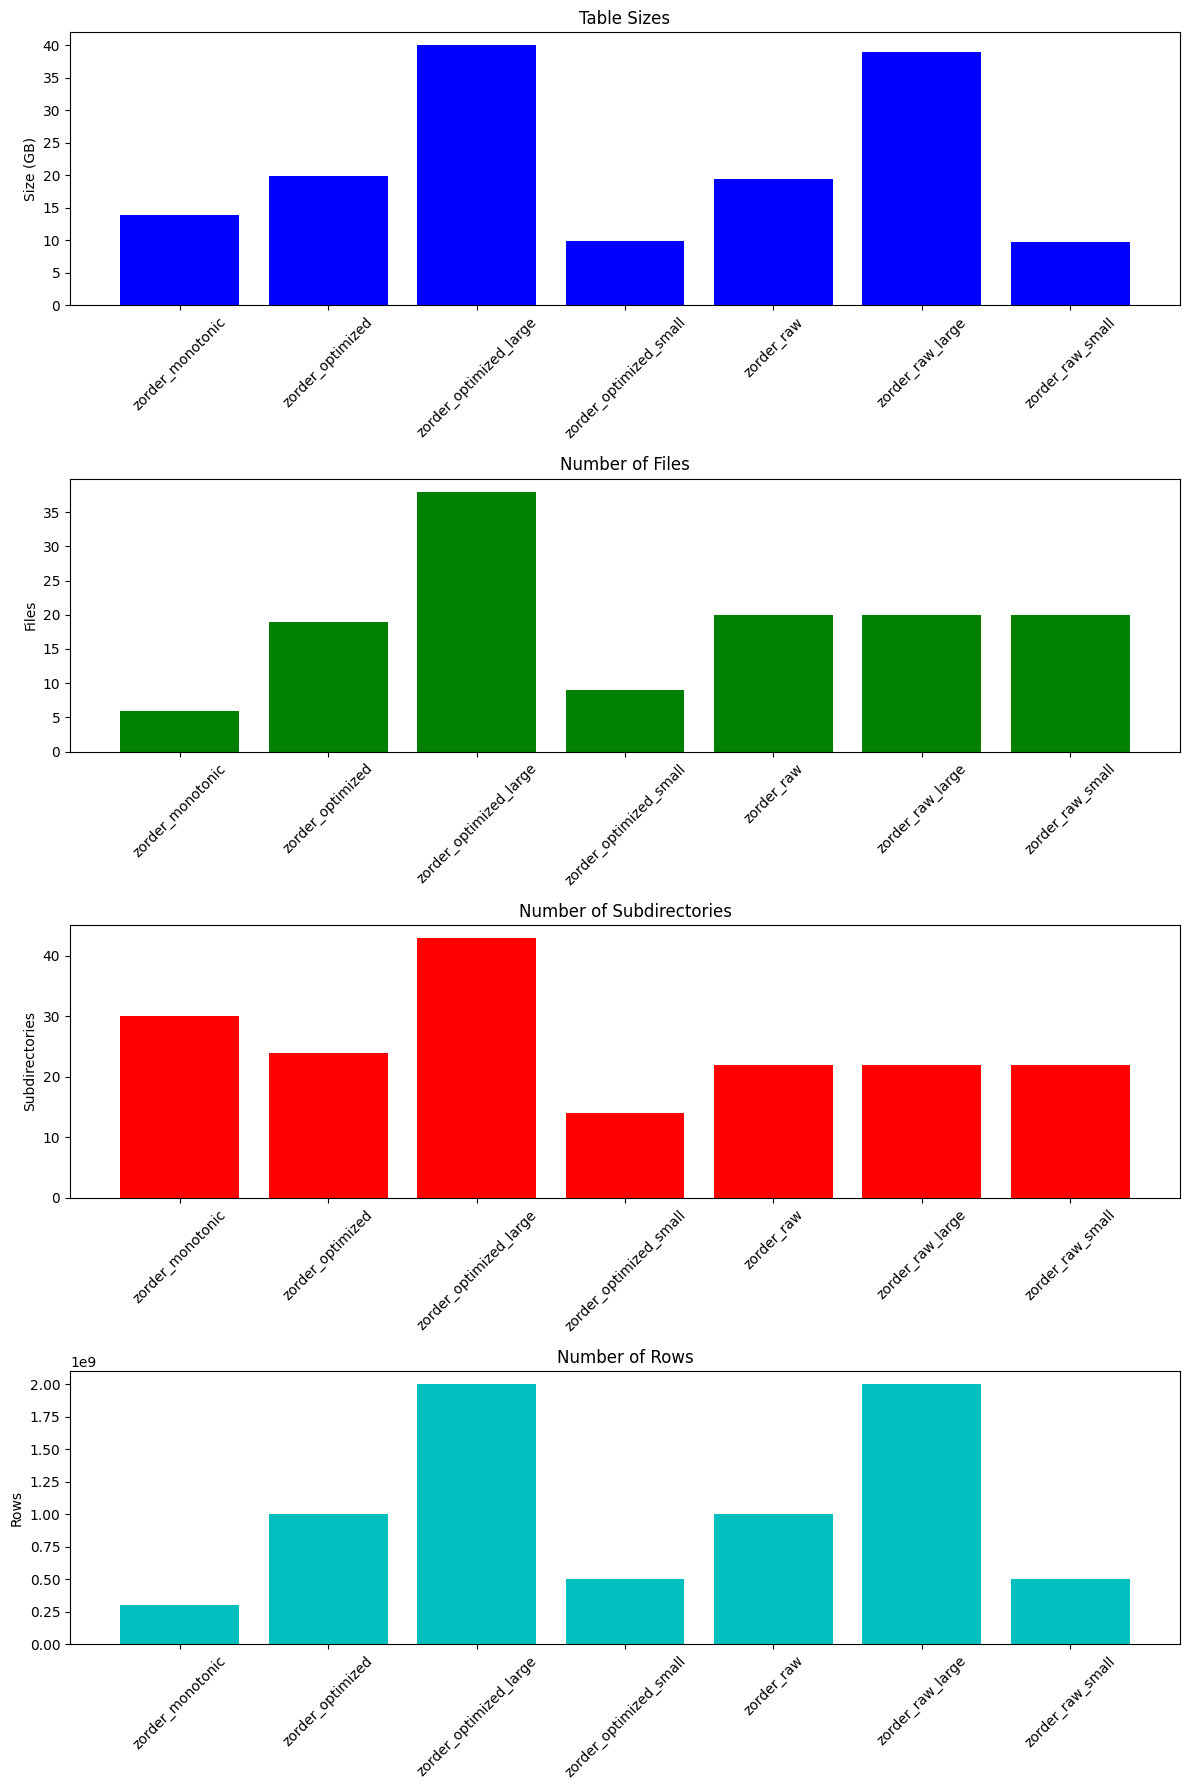

In [5]:
import subprocess
import matplotlib.pyplot as plt

spark.sql("USE zorder")

tables_df = spark.sql("SHOW TABLES")
tables = tables_df.collect()

table_details = []

for row in tables:
    if not row['isTemporary']:
        table_name = row['tableName']
        
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0]
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']
        
        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size = int(result.stdout.split()[0])
        
        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[1])
        
        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']
        
        table_details.append((table_name, hdfs_location, size, num_files, partition_columns, subdirectories, row_count))

for table in table_details:
    print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]} bytes, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

# Extract data for plotting
table_names = [table[0] for table in table_details]
hdfs_paths = [table[1] for table in table_details]
sizes = [table[2] / (1024 ** 3) for table in table_details]  # Convert bytes to GB for plotting
num_files = [table[3] for table in table_details]
subdirectories = [table[5] for table in table_details]
row_counts = [table[6] for table in table_details]

fig, axs = plt.subplots(4, 1, figsize=(12, 18))

axs[0].bar(table_names, sizes, color='b')
axs[0].set_title('Table Sizes')
axs[0].set_ylabel('Size (GB)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(table_names, num_files, color='g')
axs[1].set_title('Number of Files')
axs[1].set_ylabel('Files')
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(table_names, subdirectories, color='r')
axs[2].set_title('Number of Subdirectories')
axs[2].set_ylabel('Subdirectories')
axs[2].tick_params(axis='x', rotation=45)

axs[3].bar(table_names, row_counts, color='c')
axs[3].set_title('Number of Rows')
axs[3].set_ylabel('Rows')
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [21]:
import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import itertools
import random
from pyspark.sql.functions import lit, rand, udf, col, expr, year, month, dayofmonth, concat, lpad
from pyspark.sql.types import StringType

spark.sql("USE zorder")

# Parameters
num_pairs = 3  # Number of table pairs to create
max_rows = 8000000000  # Maximum number of rows for the largest table 8000000000

row_counts = [max_rows // (2 ** i) for i in range(num_pairs)]


"""
Create and initialize a specified number of partitioned and non-partitioned Delta Lake tables.
Each pair of tables (partitioned and non-partitioned) is dropped if it exists and then recreated 
with the specified schema.
"""
for i in range(num_pairs):
    zorder_table_name = f"zorder_eventid_actorid_table_{row_counts[i]}"
    nozorder_table_name = f"nozorder_eventid_actorid_table_{row_counts[i]}"
    
    # Drop tables if they exist
    spark.sql(f"DROP TABLE IF EXISTS {zorder_table_name}")
    spark.sql(f"DROP TABLE IF EXISTS {nozorder_table_name}")
    
    spark.sql(f"""
    CREATE TABLE {zorder_table_name} (
        date DATE,
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG
    )
    USING delta
    """)
    
    spark.sql(f"""
    CREATE TABLE {nozorder_table_name} (
        date DATE,
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG
    )
    USING delta
    """)


countries = ["USA", "Canada", "Mexico", "Brazil", "Argentina", "UK", "France", "Germany", "Italy", "Spain",
             "China", "Japan", "South Korea", "India", "Australia", "New Zealand", "South Africa", "Egypt", "Nigeria", "Kenya",
             "Russia", "Turkey", "Saudi Arabia", "Indonesia", "Thailand", "Malaysia", "Philippines", "Vietnam", "Singapore", "Pakistan",
             "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Maldives"]


def generate_data(timestamp, nrows):
    """
    Generate a DataFrame with synthetic data based on the given timestamp and number of rows.

    This function creates a DataFrame with the specified number of rows (`nrows`), where each row contains:
    - A static date derived from the provided `timestamp`.
    - A timestamp incremented by 0.1 seconds for each row.
    - A random value for the `value` column.
    - A random country selected from a predefined list of countries.
    - Sequential event and actor IDs.
    - Year, month, and day components derived from the timestamp.

    Parameters:
    timestamp (datetime): The base timestamp used to generate the date and initial timestamp for each row.
    nrows (int): The number of rows to generate in the DataFrame.

    Returns:
    DataFrame: A Spark DataFrame with the generated data, including columns for date, timestamp, value, country,
               event_id, actor_id, year, month, and day.

    Example:
    >>> from datetime import datetime
    >>> df = generate_data(datetime(2024, 1, 1), 1000)
    >>> df.show(5)
    +----------+--------------------+-------------------+---------+--------+---------+----+-----+--------+
    |      date|           timestamp|              value|  country|event_id|actor_id|year|month|     day|
    +----------+--------------------+-------------------+---------+--------+---------+----+-----+--------+
    |2024-01-01| 2024-01-01 00:00:00|0.12345678912345678|     USA  |       1|    1001|2024|    1|20240101|
    |2024-01-01| 2024-01-01 00:00:00|0.23456789123456789|  Canada  |       2|    1002|2024|    1|20240101|
    |2024-01-01| 2024-01-01 00:00:00|0.34567891234567891|  Mexico  |       3|    1003|2024|    1|20240101|
    |2024-01-01| 2024-01-01 00:00:00|0.45678912345678912|  Brazil  |       4|    1004|2024|    1|20240101|
    |2024-01-01| 2024-01-01 00:00:00|0.56789123456789123|Argentina |       5|    1005|2024|    1|20240101|
    +----------+--------------------+-------------------+---------+--------+---------+----+-----+--------+
    """
    date = timestamp.date()
    return spark.range(nrows).select(
        lit(date).alias("date"),
        (lit(timestamp) + expr("INTERVAL 0.1 SECOND") * col("id")).alias("timestamp"),
        rand().alias("value"),
        element_at(array([lit(country) for country in countries]), (rand() * len(countries)).cast("int") + 1).alias("country"),
        (rand() * 1000000).cast("long").alias("event_id"),
        (rand() * 10000).cast("long").alias("actor_id"),
        year((lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id"))).alias("year"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("month"),
        concat(
            year((lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id"))).cast("string"),
            lpad(month((lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id"))).cast("string"), 2, '0'),
            lpad(dayofmonth((lit(timestamp) + expr("INTERVAL 1 SECOND") * col("id"))).cast("string"), 2, '0')
        ).cast("long").alias("day")
    )


for i, rows in enumerate(row_counts):
    timestamp = datetime(2024, 1, 1) + timedelta(hours=i)
    
    zorder_table_name = f"zorder_eventid_actorid_table_{row_counts[i]}"
    nozorder_table_name = f"nozorder_eventid_actorid_table_{row_counts[i]}"
    
    insert_data_part_table_name = generate_data(timestamp, rows)
    insert_data_part_table_name.write.format("delta").mode("append").saveAsTable(zorder_table_name)
    
    insert_data_nopart_table_name = generate_data(timestamp, rows)
    insert_data_nopart_table_name.write.format("delta").mode("append").saveAsTable(nozorder_table_name)



24/07/16 15:28:38 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_actorid_table_8000000000` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/16 15:28:40 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`nozorder_eventid_actorid_table_8000000000` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/16 15:28:42 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_actorid_table_4000000000` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/16 15:28:44 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider de

In [22]:
spark.sql("""
show tables
""").show(truncate=False)

+---------+-----------------------------------------+-----------+
|namespace|tableName                                |isTemporary|
+---------+-----------------------------------------+-----------+
|zorder   |nozorder_eventid_actorid_table_2000      |false      |
|zorder   |nozorder_eventid_actorid_table_2000000000|false      |
|zorder   |nozorder_eventid_actorid_table_4000      |false      |
|zorder   |nozorder_eventid_actorid_table_4000000000|false      |
|zorder   |nozorder_eventid_actorid_table_8000      |false      |
|zorder   |nozorder_eventid_actorid_table_8000000000|false      |
|zorder   |zorder_eventid_actorid_table_2000        |false      |
|zorder   |zorder_eventid_actorid_table_2000000000  |false      |
|zorder   |zorder_eventid_actorid_table_4000        |false      |
|zorder   |zorder_eventid_actorid_table_4000000000  |false      |
|zorder   |zorder_eventid_actorid_table_8000        |false      |
|zorder   |zorder_eventid_actorid_table_8000000000  |false      |
+---------

In [24]:
from delta.tables import DeltaTable

delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2000000000")
%time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4000000000")
%time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")
delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8000000000")
%time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


24/07/17 08:21:05 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/07/17 08:21:05 ERROR DeltaFileFormatWriter: Aborting job f3165593-3f09-4070-b818-b277124bb8a5.
org.apache.spark.SparkException: Job aborted due to stage failure: Master removed our application: KILLED
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(

Py4JJavaError: An error occurred while calling o2285.executeZOrderBy.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.util.ThreadUtils$.parmap(ThreadUtils.scala:387)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.$anonfun$optimize$1(OptimizeTableCommand.scala:279)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:140)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:138)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.recordFrameProfile(OptimizeTableCommand.scala:225)
	at org.apache.spark.sql.delta.metering.DeltaLogging.$anonfun$recordDeltaOperationInternal$1(DeltaLogging.scala:133)
	at com.databricks.spark.util.DatabricksLogging.recordOperation(DatabricksLogging.scala:128)
	at com.databricks.spark.util.DatabricksLogging.recordOperation$(DatabricksLogging.scala:117)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.recordOperation(OptimizeTableCommand.scala:225)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperationInternal(DeltaLogging.scala:132)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation(DeltaLogging.scala:122)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation$(DeltaLogging.scala:112)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.recordDeltaOperation(OptimizeTableCommand.scala:225)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.optimize(OptimizeTableCommand.scala:261)
	at org.apache.spark.sql.delta.commands.OptimizeTableCommand.run(OptimizeTableCommand.scala:182)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:220)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:92)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:89)
	at org.apache.spark.sql.delta.util.AnalysisHelper.toDataset(AnalysisHelper.scala:82)
	at org.apache.spark.sql.delta.util.AnalysisHelper.toDataset$(AnalysisHelper.scala:81)
	at io.delta.tables.DeltaOptimizeBuilder.toDataset(DeltaOptimizeBuilder.scala:43)
	at io.delta.tables.DeltaOptimizeBuilder.$anonfun$execute$1(DeltaOptimizeBuilder.scala:100)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.delta.DeltaTableUtils$.withActiveSession(DeltaTable.scala:491)
	at io.delta.tables.DeltaOptimizeBuilder.execute(DeltaOptimizeBuilder.scala:85)
	at io.delta.tables.DeltaOptimizeBuilder.executeZOrderBy(DeltaOptimizeBuilder.scala:80)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Master removed our application: KILLED
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.sql.delta.files.DeltaFileFormatWriter$.$anonfun$executeWrite$1(DeltaFileFormatWriter.scala:263)
	at org.apache.spark.sql.delta.files.DeltaFileFormatWriter$.writeAndCommit(DeltaFileFormatWriter.scala:295)
	at org.apache.spark.sql.delta.files.DeltaFileFormatWriter$.executeWrite(DeltaFileFormatWriter.scala:234)
	at org.apache.spark.sql.delta.files.DeltaFileFormatWriter$.write(DeltaFileFormatWriter.scala:214)
	at org.apache.spark.sql.delta.files.TransactionalWrite.$anonfun$writeFiles$1(TransactionalWrite.scala:433)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles(TransactionalWrite.scala:391)
	at org.apache.spark.sql.delta.files.TransactionalWrite.writeFiles$(TransactionalWrite.scala:364)
	at org.apache.spark.sql.delta.OptimisticTransaction.writeFiles(OptimisticTransaction.scala:142)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.runOptimizeBinJob(OptimizeTableCommand.scala:466)
	at org.apache.spark.sql.delta.commands.OptimizeExecutor.$anonfun$optimize$6(OptimizeTableCommand.scala:280)
	at org.apache.spark.util.ThreadUtils$.$anonfun$parmap$2(ThreadUtils.scala:384)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at java.util.concurrent.ForkJoinTask$RunnableExecuteAction.exec(ForkJoinTask.java:1402)
	at java.util.concurrent.ForkJoinTask.doExec(ForkJoinTask.java:289)
	at java.util.concurrent.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:1056)
	at java.util.concurrent.ForkJoinPool.runWorker(ForkJoinPool.java:1692)
	at java.util.concurrent.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:175)


Py4JJavaError: An error occurred while calling z:io.delta.tables.DeltaTable.forPath.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:750)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:122)
	at org.apache.spark.SparkContext.broadcastInternal(SparkContext.scala:1659)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1644)
	at org.apache.spark.sql.execution.datasources.json.JsonFileFormat.buildReader(JsonFileFormat.scala:99)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:138)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:129)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:346)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:548)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:537)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:575)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:527)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:455)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:454)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:498)
	at org.apache.spark.sql.execution.FilterExec.inputRDDs(basicPhysicalOperators.scala:242)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:51)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:751)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:364)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:445)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:3573)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:3573)
	at org.apache.spark.sql.delta.Snapshot.protocolAndMetadataReconstruction(Snapshot.scala:229)
	at org.apache.spark.sql.delta.Snapshot.x$1$lzycompute(Snapshot.scala:138)
	at org.apache.spark.sql.delta.Snapshot.x$1(Snapshot.scala:133)
	at org.apache.spark.sql.delta.Snapshot._metadata$lzycompute(Snapshot.scala:133)
	at org.apache.spark.sql.delta.Snapshot._metadata(Snapshot.scala:133)
	at org.apache.spark.sql.delta.Snapshot.metadata(Snapshot.scala:202)
	at org.apache.spark.sql.delta.Snapshot.toString(Snapshot.scala:416)
	at java.lang.String.valueOf(String.java:2994)
	at java.lang.StringBuilder.append(StringBuilder.java:136)
	at org.apache.spark.sql.delta.Snapshot.$anonfun$new$1(Snapshot.scala:419)
	at org.apache.spark.sql.delta.Snapshot.$anonfun$logInfo$1(Snapshot.scala:396)
	at org.apache.spark.internal.Logging.logInfo(Logging.scala:60)
	at org.apache.spark.internal.Logging.logInfo$(Logging.scala:59)
	at org.apache.spark.sql.delta.Snapshot.logInfo(Snapshot.scala:396)
	at org.apache.spark.sql.delta.Snapshot.<init>(Snapshot.scala:419)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$createSnapshot$2(SnapshotManagement.scala:503)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment(SnapshotManagement.scala:628)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotFromGivenOrEquivalentLogSegment$(SnapshotManagement.scala:616)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshotFromGivenOrEquivalentLogSegment(DeltaLog.scala:72)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot(SnapshotManagement.scala:496)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshot$(SnapshotManagement.scala:489)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshot(DeltaLog.scala:72)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$createSnapshotAtInitInternal$1(SnapshotManagement.scala:450)
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotAtInitInternal(SnapshotManagement.scala:447)
	at org.apache.spark.sql.delta.SnapshotManagement.createSnapshotAtInitInternal$(SnapshotManagement.scala:444)
	at org.apache.spark.sql.delta.DeltaLog.createSnapshotAtInitInternal(DeltaLog.scala:72)
	at org.apache.spark.sql.delta.SnapshotManagement.$anonfun$getSnapshotAtInit$1(SnapshotManagement.scala:439)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:140)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:138)
	at org.apache.spark.sql.delta.DeltaLog.recordFrameProfile(DeltaLog.scala:72)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit(SnapshotManagement.scala:434)
	at org.apache.spark.sql.delta.SnapshotManagement.getSnapshotAtInit$(SnapshotManagement.scala:433)
	at org.apache.spark.sql.delta.DeltaLog.getSnapshotAtInit(DeltaLog.scala:72)
	at org.apache.spark.sql.delta.SnapshotManagement.$init$(SnapshotManagement.scala:60)
	at org.apache.spark.sql.delta.DeltaLog.<init>(DeltaLog.scala:78)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$4(DeltaLog.scala:779)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$3(DeltaLog.scala:774)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:140)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:138)
	at org.apache.spark.sql.delta.DeltaLog$.recordFrameProfile(DeltaLog.scala:598)
	at org.apache.spark.sql.delta.metering.DeltaLogging.$anonfun$recordDeltaOperationInternal$1(DeltaLogging.scala:133)
	at com.databricks.spark.util.DatabricksLogging.recordOperation(DatabricksLogging.scala:128)
	at com.databricks.spark.util.DatabricksLogging.recordOperation$(DatabricksLogging.scala:117)
	at org.apache.spark.sql.delta.DeltaLog$.recordOperation(DeltaLog.scala:598)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperationInternal(DeltaLogging.scala:132)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation(DeltaLogging.scala:122)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordDeltaOperation$(DeltaLogging.scala:112)
	at org.apache.spark.sql.delta.DeltaLog$.recordDeltaOperation(DeltaLog.scala:598)
	at org.apache.spark.sql.delta.DeltaLog$.createDeltaLog$1(DeltaLog.scala:773)
	at org.apache.spark.sql.delta.DeltaLog$.$anonfun$apply$5(DeltaLog.scala:791)
	at com.google.common.cache.LocalCache$LocalManualCache$1.load(LocalCache.java:4792)
	at com.google.common.cache.LocalCache$LoadingValueReference.loadFuture(LocalCache.java:3599)
	at com.google.common.cache.LocalCache$Segment.loadSync(LocalCache.java:2379)
	at com.google.common.cache.LocalCache$Segment.lockedGetOrLoad(LocalCache.java:2342)
	at com.google.common.cache.LocalCache$Segment.get(LocalCache.java:2257)
	at com.google.common.cache.LocalCache.get(LocalCache.java:4000)
	at com.google.common.cache.LocalCache$LocalManualCache.get(LocalCache.java:4789)
	at org.apache.spark.sql.delta.DeltaLog$.getDeltaLogFromCache$1(DeltaLog.scala:790)
	at org.apache.spark.sql.delta.DeltaLog$.apply(DeltaLog.scala:800)
	at org.apache.spark.sql.delta.DeltaLog$.forTable(DeltaLog.scala:677)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$deltaLog$1(DeltaTableV2.scala:91)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2$.withEnrichedUnsupportedTableException(DeltaTableV2.scala:364)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.deltaLog$lzycompute(DeltaTableV2.scala:91)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.deltaLog(DeltaTableV2.scala:89)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$initialSnapshot$4(DeltaTableV2.scala:144)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.$anonfun$initialSnapshot$1(DeltaTableV2.scala:144)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2$.withEnrichedUnsupportedTableException(DeltaTableV2.scala:364)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.initialSnapshot$lzycompute(DeltaTableV2.scala:143)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.initialSnapshot(DeltaTableV2.scala:123)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.toBaseRelation$lzycompute(DeltaTableV2.scala:235)
	at org.apache.spark.sql.delta.catalog.DeltaTableV2.toBaseRelation(DeltaTableV2.scala:233)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.$anonfun$createRelation$5(DeltaDataSource.scala:250)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile(DeltaLogging.scala:140)
	at org.apache.spark.sql.delta.metering.DeltaLogging.recordFrameProfile$(DeltaLogging.scala:138)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.recordFrameProfile(DeltaDataSource.scala:49)
	at org.apache.spark.sql.delta.sources.DeltaDataSource.createRelation(DeltaDataSource.scala:209)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:346)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:229)
	at org.apache.spark.sql.DataFrameReader.$anonfun$load$2(DataFrameReader.scala:211)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:211)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:186)
	at io.delta.tables.DeltaTable$.forPath(DeltaTable.scala:717)
	at io.delta.tables.DeltaTable$.forPath(DeltaTable.scala:750)
	at io.delta.tables.DeltaTable.forPath(DeltaTable.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [5]:
from delta.tables import DeltaTable

delta_table_obj = DeltaTable.forPath(spark, "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8000000000")
%time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


CPU times: user 4.66 s, sys: 10.4 s, total: 15.1 s
Wall time: 2h 11min 2s


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>,de

In [6]:
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
delta_table_obj = DeltaTable.forPath(spark, 'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2000000000')
%time delta_table_obj.vacuum(0)
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
delta_table_obj = DeltaTable.forPath(spark, 'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4000000000')
%time delta_table_obj.vacuum(0)
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
delta_table_obj = DeltaTable.forPath(spark, 'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8000000000')
%time delta_table_obj.vacuum(0)

Deleted 55 files and directories in a total of 1 directories.
CPU times: user 40.8 ms, sys: 50 ms, total: 90.7 ms
Wall time: 23.5 s


Deleted 15 files and directories in a total of 1 directories.
CPU times: user 55.1 ms, sys: 80.8 ms, total: 136 ms
Wall time: 19.8 s


Deleted 15 files and directories in a total of 1 directories.
CPU times: user 50.4 ms, sys: 63.8 ms, total: 114 ms
Wall time: 19.1 s


DataFrame[]

Table: nozorder_eventid_actorid_table_2000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/nozorder_eventid_actorid_table_2000, Size: 108985 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Number of Rows: 2000
Table: nozorder_eventid_actorid_table_2000000000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/nozorder_eventid_actorid_table_2000000000, Size: 43065201585 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Number of Rows: 2000000000
Table: nozorder_eventid_actorid_table_4000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/nozorder_eventid_actorid_table_4000, Size: 159142 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Number of Rows: 4000
Table: nozorder_eventid_actorid_table_4000000000, HDFS Directory: hdfs://192.168.0.144:9000/datalake/zorder/nozorder_eventid_actorid_table_4000000000, Size: 86127437942 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 17, Numbe

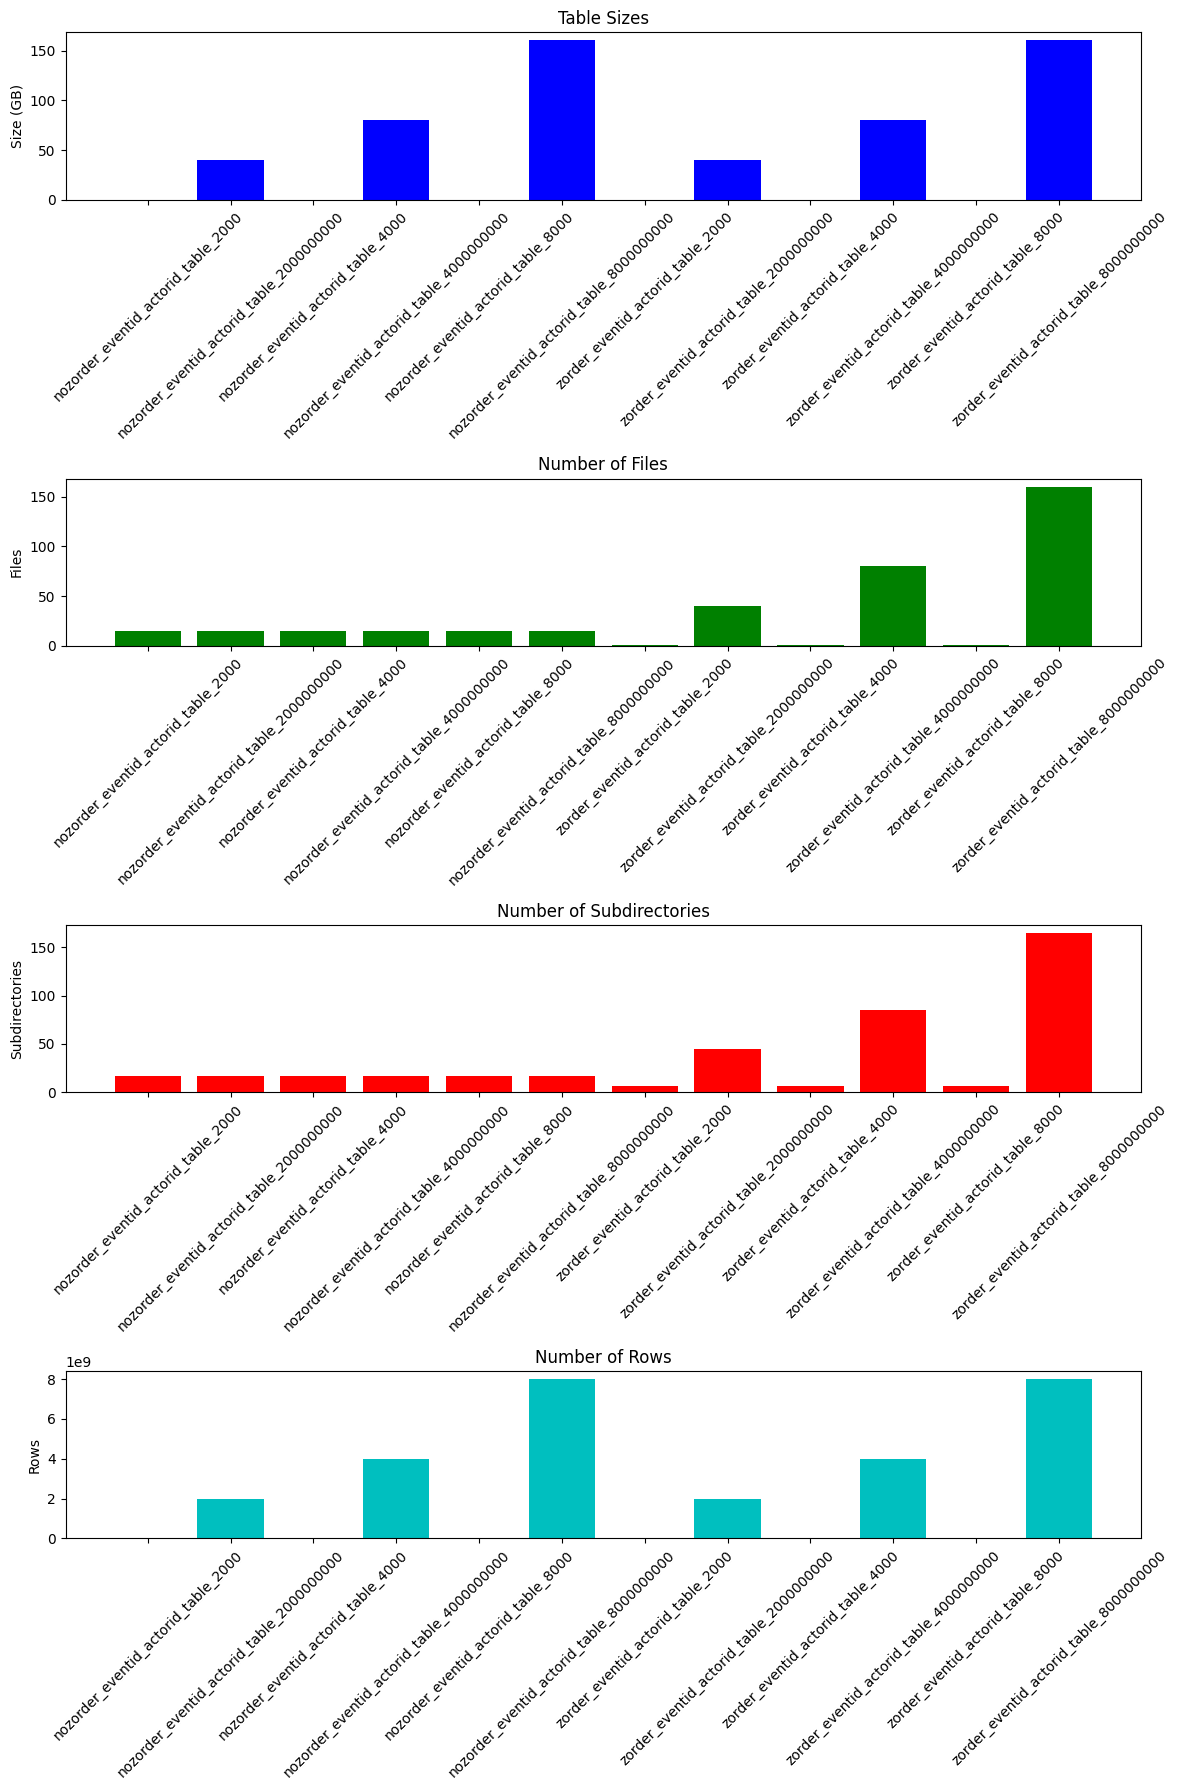

In [9]:
import subprocess
import matplotlib.pyplot as plt

spark.sql("USE zorder")

tables_df = spark.sql("SHOW TABLES")
tables = tables_df.collect()

table_details = []

for row in tables:
    if not row['isTemporary']:
        table_name = row['tableName']
        
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0]
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']
        
        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size = int(result.stdout.split()[0])
        
        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[1])
        
        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']
        
        table_details.append((table_name, hdfs_location, size, num_files, partition_columns, subdirectories, row_count))

for table in table_details:
    print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]} bytes, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

# Extract data for plotting
table_names = [table[0] for table in table_details]
hdfs_paths = [table[1] for table in table_details]
sizes = [table[2] / (1024 ** 3) for table in table_details]  # Convert bytes to GB for plotting
num_files = [table[3] for table in table_details]
subdirectories = [table[5] for table in table_details]
row_counts = [table[6] for table in table_details]

fig, axs = plt.subplots(4, 1, figsize=(12, 18))

axs[0].bar(table_names, sizes, color='b')
axs[0].set_title('Table Sizes')
axs[0].set_ylabel('Size (GB)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(table_names, num_files, color='g')
axs[1].set_title('Number of Files')
axs[1].set_ylabel('Files')
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(table_names, subdirectories, color='r')
axs[2].set_title('Number of Subdirectories')
axs[2].set_ylabel('Subdirectories')
axs[2].tick_params(axis='x', rotation=45)

axs[3].bar(table_names, row_counts, color='c')
axs[3].set_title('Number of Rows')
axs[3].set_ylabel('Rows')
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


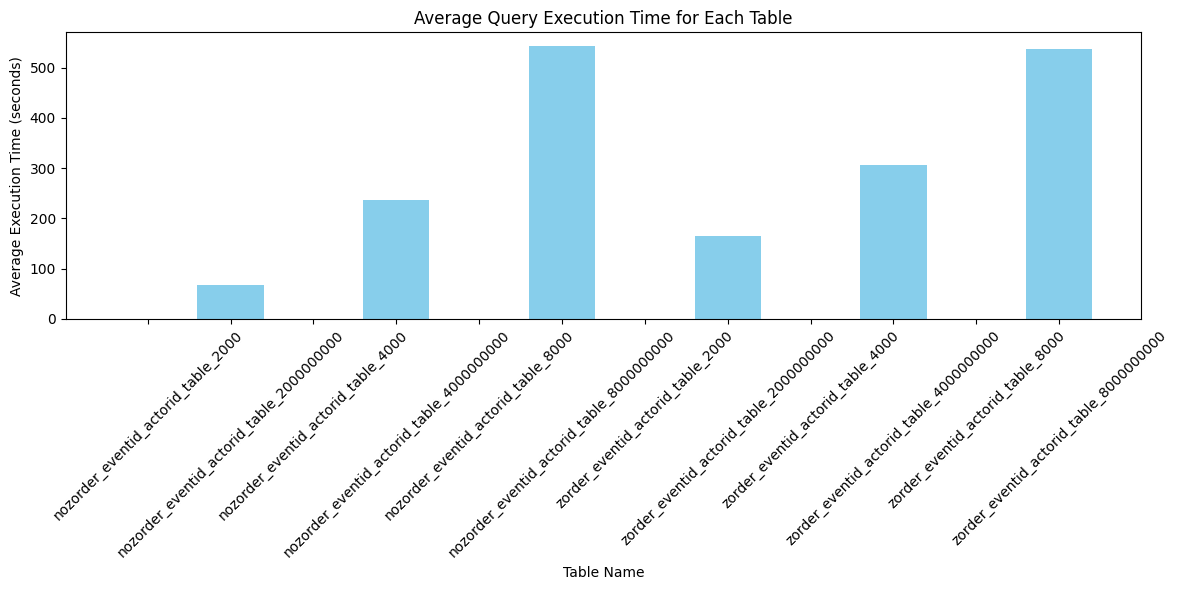

In [10]:
import time
import matplotlib.pyplot as plt
import pandas as pd

tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
num_executions = 2

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).collect()  # Execute the query
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"SELECT avg(value) FROM {table}"
        execution_time = measure_execution_time(query)
        execution_times[table].append(execution_time)

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


nozorder_eventid_actorid_table_2000: 1.2084262371063232 seconds


nozorder_eventid_actorid_table_2000000000: 163.0458288192749 seconds


nozorder_eventid_actorid_table_4000: 1.8031346797943115 seconds


nozorder_eventid_actorid_table_4000000000: 309.6799337863922 seconds
nozorder_eventid_actorid_table_8000: 1.1069419384002686 seconds


nozorder_eventid_actorid_table_8000000000: 679.5600533485413 seconds
zorder_eventid_actorid_table_2000: 1.113508701324463 seconds


zorder_eventid_actorid_table_2000000000: 87.94923782348633 seconds
zorder_eventid_actorid_table_4000: 0.8735909461975098 seconds


zorder_eventid_actorid_table_4000000000: 122.60063052177429 seconds
zorder_eventid_actorid_table_8000: 0.8827464580535889 seconds


zorder_eventid_actorid_table_8000000000: 214.1814889907837 seconds
                                        Table  Average Execution Time
0         nozorder_eventid_actorid_table_2000                1.208426
1   nozorder_eventid_actorid_table_2000000000              163.045829
2         nozorder_eventid_actorid_table_4000                1.803135
3   nozorder_eventid_actorid_table_4000000000              309.679934
4         nozorder_eventid_actorid_table_8000                1.106942
5   nozorder_eventid_actorid_table_8000000000              679.560053
6           zorder_eventid_actorid_table_2000                1.113509
7     zorder_eventid_actorid_table_2000000000               87.949238
8           zorder_eventid_actorid_table_4000                0.873591
9     zorder_eventid_actorid_table_4000000000              122.600631
10          zorder_eventid_actorid_table_8000                0.882746
11    zorder_eventid_actorid_table_8000000000              214.181489


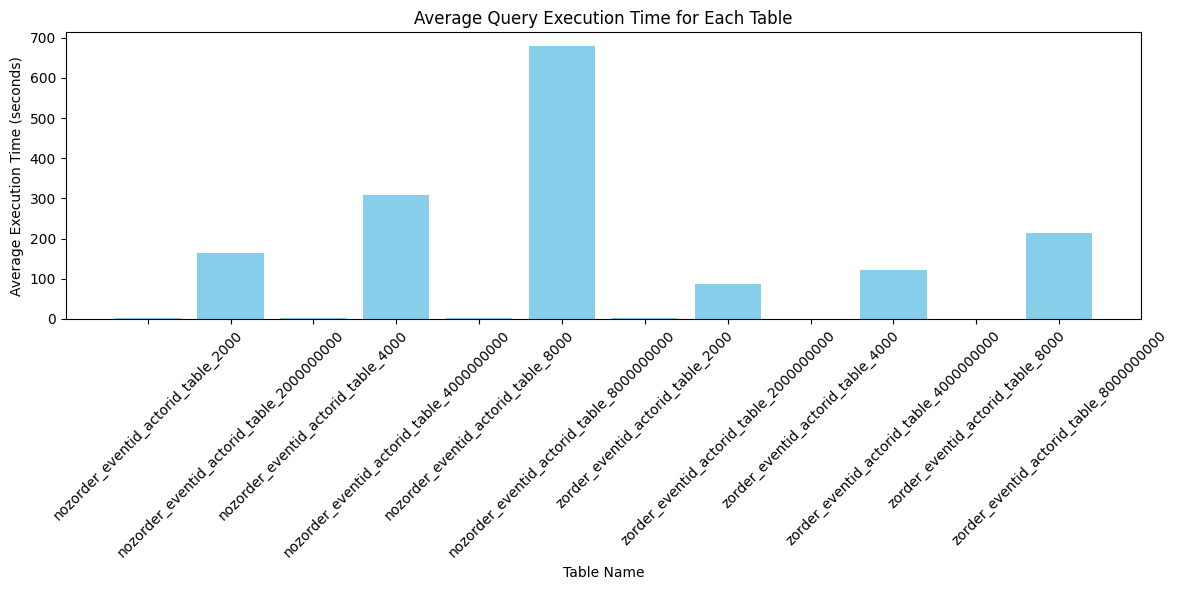

In [5]:
import time
import matplotlib.pyplot as plt
import pandas as pd

tables_df = spark.sql("SHOW TABLES")
tables = [row['tableName'] for row in tables_df.collect() if not row['isTemporary']]
num_executions = 1

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).collect() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"SELECT avg(value) FROM {table} WHERE event_id BETWEEN 459999 AND 999999 AND actor_id BETWEEN 4500 AND 9999"        
        execution_time = measure_execution_time(query)
        print(f"{table}: {execution_time} seconds")
        execution_times[table].append(execution_time)

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


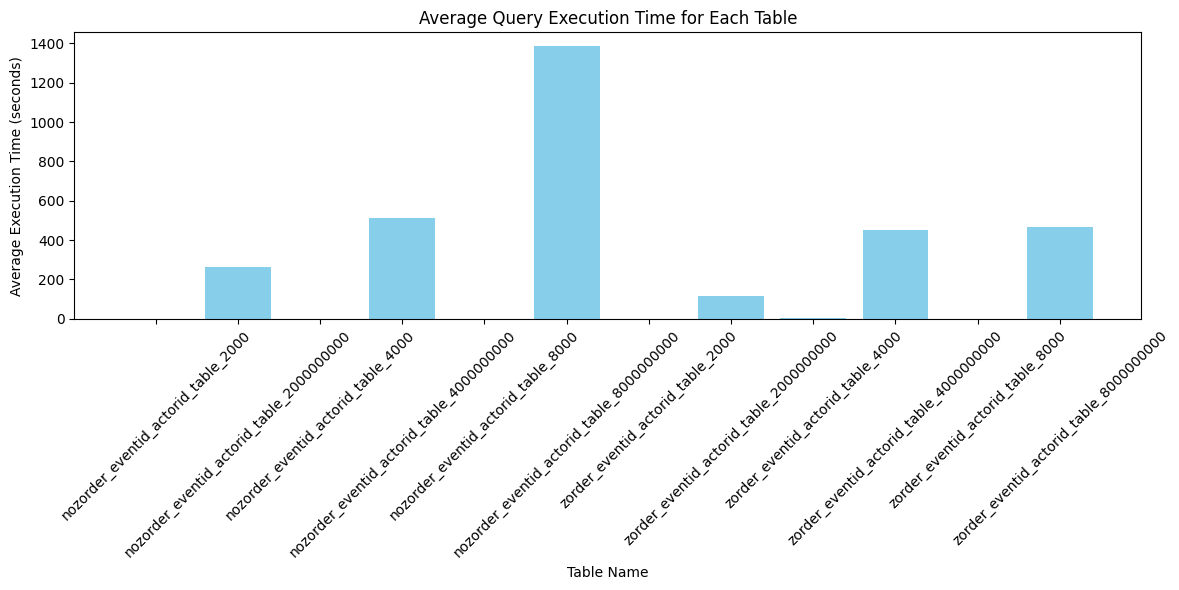

In [15]:
plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
print(df)

                                        Table  Average Execution Time
0         nozorder_eventid_actorid_table_2000                0.724870
1   nozorder_eventid_actorid_table_2000000000              262.320345
2         nozorder_eventid_actorid_table_4000                0.617689
3   nozorder_eventid_actorid_table_4000000000              514.766068
4         nozorder_eventid_actorid_table_8000                0.671024
5   nozorder_eventid_actorid_table_8000000000             1386.293081
6           zorder_eventid_actorid_table_2000                1.410840
7     zorder_eventid_actorid_table_2000000000              115.006382
8           zorder_eventid_actorid_table_4000                2.334614
9     zorder_eventid_actorid_table_4000000000              450.694919
10          zorder_eventid_actorid_table_8000                1.842960
11    zorder_eventid_actorid_table_8000000000              466.151372


+--------------------+-------------------+-------------------+-------------------+-------------------+
|                path|min_increasing_int1|max_increasing_int1|min_increasing_int2|max_increasing_int2|
+--------------------+-------------------+-------------------+-------------------+-------------------+
|part-00000-0d96dd...|                  0|              64462|                  0|               1278|
|part-00001-628568...|              32492|             129467|                  0|               1278|
|part-00002-05573f...|                  0|             129467|                636|               1920|
|part-00003-a5ce2e...|                  0|              76161|               1279|               2562|
|part-00004-d3519c...|              64463|             129467|               1279|               2562|
|part-00005-0cfaf5...|              96865|             193299|                  0|               2562|
|part-00006-34aecd...|             129468|             256970|           

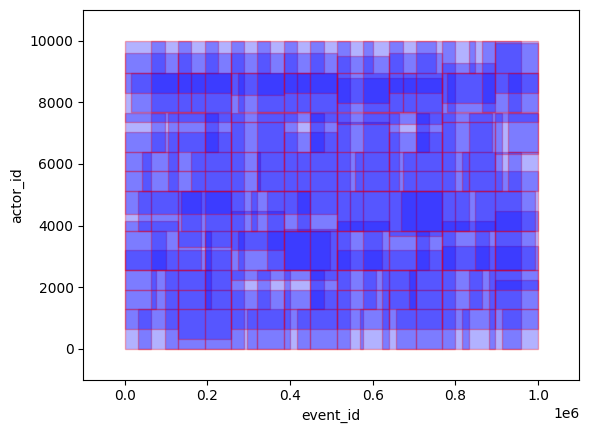

In [12]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row



file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8000000000/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['event_id']
        max_increasing_int1 = stats['maxValues']['event_id']
        min_increasing_int2 = stats['minValues']['actor_id']
        max_increasing_int2 = stats['maxValues']['actor_id']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()
result_df.show()
fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='red', facecolor='blue', alpha=0.3)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('event_id')
ax.set_ylabel('actor_id')
#ax.set_title('Z-Order monotonically increasing attributes')

plt.savefig('zorder_monotonic.png', dpi=500)
plt.show()



In [ ]:
############################################################################################################################################################

In [8]:
# Create Product Dimension Table
spark.sql("""
CREATE TABLE product_dim (
    product_id INT,
    product_name STRING,
    product_category STRING,
    product_price DOUBLE
)
USING delta;
""")

# Create Location Dimension Table
spark.sql("""
CREATE TABLE location_dim (
    location_id INT,
    location_name STRING,
    city STRING,
    state STRING,
    country STRING
)
USING delta;
""")

# Create Department Dimension Table
spark.sql("""
CREATE TABLE department_dim (
    department_id INT,
    department_name STRING,
    department_head STRING
)
USING delta;
""")

# Create Campaign Dimension Table
spark.sql("""
CREATE TABLE campaign_dim (
    campaign_id INT,
    campaign_name STRING,
    start_date DATE,
    end_date DATE
)
USING delta;
""")

# Create Customer Dimension Table
spark.sql("""
CREATE TABLE customer_dim (
    customer_id INT,
    customer_name STRING,
    customer_email STRING,
    customer_segment STRING
)
USING delta;
""")


24/07/29 20:37:05 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`product_dim` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:37:05 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`location_dim` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:37:06 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`department_dim` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:37:06 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`campaign_dim` into Hiv

DataFrame[]

In [9]:
# Inserting data into product_dimension
spark.sql("""
INSERT INTO product_dim VALUES
(1, 'Product A', 'Category 1', 19.99),
(2, 'Product B', 'Category 2', 29.99),
(3, 'Product C', 'Category 1', 39.99),
(4, 'Product D', 'Category 3', 49.99),
(5, 'Product E', 'Category 2', 59.99),
(6, 'Product F', 'Category 4', 69.99),
(7, 'Product G', 'Category 1', 79.99),
(8, 'Product H', 'Category 5', 89.99),
(9, 'Product I', 'Category 3', 99.99),
(10, 'Product J', 'Category 2', 109.99)
""")

# Inserting data into location_dimension
spark.sql("""
INSERT INTO location_dim VALUES
(1, 'Location A', 'New York', 'NY', 'USA'),
(2, 'Location B', 'Los Angeles', 'CA', 'USA'),
(3, 'Location C', 'Chicago', 'IL', 'USA'),
(4, 'Location D', 'Houston', 'TX', 'USA'),
(5, 'Location E', 'Phoenix', 'AZ', 'USA'),
(6, 'Location F', 'Philadelphia', 'PA', 'USA'),
(7, 'Location G', 'San Antonio', 'TX', 'USA'),
(8, 'Location H', 'San Diego', 'CA', 'USA'),
(9, 'Location I', 'Dallas', 'TX', 'USA'),
(10, 'Location J', 'San Jose', 'CA', 'USA')
""")

# Inserting data into department_dimension
spark.sql("""
INSERT INTO department_dim VALUES
(1, 'Sales', 'Alice Smith'),
(2, 'Marketing', 'Bob Jones'),
(3, 'Engineering', 'Charlie Brown'),
(4, 'HR', 'Diana Green'),
(5, 'Finance', 'Eve White'),
(6, 'Product', 'Frank Black'),
(7, 'Customer Support', 'Grace Blue'),
(8, 'IT', 'Hank Red'),
(9, 'Logistics', 'Ivy Yellow'),
(10, 'Legal', 'Jack Orange')
""")

# Inserting data into campaign_dimension
spark.sql("""
INSERT INTO campaign_dim VALUES
(1, 'Campaign 1', '2024-01-01', '2024-01-31'),
(2, 'Campaign 2', '2024-02-01', '2024-02-28'),
(3, 'Campaign 3', '2024-03-01', '2024-03-31'),
(4, 'Campaign 4', '2024-04-01', '2024-04-30'),
(5, 'Campaign 5', '2024-05-01', '2024-05-31'),
(6, 'Campaign 6', '2024-06-01', '2024-06-30'),
(7, 'Campaign 7', '2024-07-01', '2024-07-31'),
(8, 'Campaign 8', '2024-08-01', '2024-08-31'),
(9, 'Campaign 9', '2024-09-01', '2024-09-30'),
(10, 'Campaign 10', '2024-10-01', '2024-10-31')
""")

# Inserting data into customer_dimension
spark.sql("""
INSERT INTO customer_dim VALUES
(1, 'John Doe', 'john.doe@example.com', 'Premium'),
(2, 'Jane Smith', 'jane.smith@example.com', 'Standard'),
(3, 'Michael Brown', 'michael.brown@example.com', 'Standard'),
(4, 'Emily Davis', 'emily.davis@example.com', 'Premium'),
(5, 'Chris Johnson', 'chris.johnson@example.com', 'Basic'),
(6, 'Olivia Martin', 'olivia.martin@example.com', 'Premium'),
(7, 'Liam Lee', 'liam.lee@example.com', 'Standard'),
(8, 'Sophia Wilson', 'sophia.wilson@example.com', 'Basic'),
(9, 'Jackson Moore', 'jackson.moore@example.com', 'Standard'),
(10, 'Ava Taylor', 'ava.taylor@example.com', 'Premium')
""")


DataFrame[]

In [7]:
import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import itertools
import random
from pyspark.sql.functions import lit, rand, udf, col, expr, year, month, dayofmonth, concat, lpad
from pyspark.sql.types import StringType


# Parameters
num_pairs = 3  # Number of table pairs to create
max_rows = 8  # Maximum number of rows for the largest table 8000000000

row_counts = [max_rows // (2 ** i) for i in range(num_pairs)]


"""
Create and initialize a specified number of partitioned and non-partitioned Delta Lake tables.
Each pair of tables (partitioned and non-partitioned) is dropped if it exists and then recreated 
with the specified schema.
"""
for i in range(num_pairs):
    zorder_table_name = f"zorder_eventid_actorid_table_{row_counts[i]}"
    zorder_table_name_sd = f"zorder_eventid_table_{row_counts[i]}"
    
    spark.sql(f"DROP TABLE IF EXISTS {zorder_table_name}")
    spark.sql(f"DROP TABLE IF EXISTS {zorder_table_name_sd}")
    
    spark.sql(f"""
    CREATE TABLE {zorder_table_name} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)

    spark.sql(f"""
    CREATE TABLE {zorder_table_name_sd} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)





24/07/29 20:36:27 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_actorid_table_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:36:27 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/07/29 20:36:30 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_table_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:36:31 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_actorid_table_4` into Hive metastore in Spark SQL specific format, which is NOT compat

In [11]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    table_name = path.split("/")[-1]
    print(f"Optimizing table: {table_name}")
    %time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


table_paths = [
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    table_name = path.split("/")[-1]
    print(f"Optimizing table: {table_name}")
    %time delta_table_obj.optimize().executeZOrderBy("event_id")

Optimizing table: zorder_eventid_actorid_table_2


CPU times: user 1.3 s, sys: 2.06 s, total: 3.36 s
Wall time: 51min 9s
Optimizing table: zorder_eventid_actorid_table_4


CPU times: user 2.84 s, sys: 3.9 s, total: 6.74 s
Wall time: 1h 52min 8s
Optimizing table: zorder_eventid_actorid_table_8


CPU times: user 6.01 s, sys: 8.46 s, total: 14.5 s
Wall time: 3h 57min 26s
Optimizing table: zorder_eventid_table_2


CPU times: user 1.16 s, sys: 1.74 s, total: 2.9 s
Wall time: 46min 4s
Optimizing table: zorder_eventid_table_4


CPU times: user 2.66 s, sys: 3.28 s, total: 5.94 s
Wall time: 1h 46min 18s
Optimizing table: zorder_eventid_table_8


CPU times: user 5.98 s, sys: 7.22 s, total: 13.2 s
Wall time: 4h 1min 54s


In [42]:
spark.sql("""
show tables
""").show(truncate = False)


+---------+--------------------------------+-----------+
|namespace|tableName                       |isTemporary|
+---------+--------------------------------+-----------+
|zorder   |nozorder_eventid_actorid_table_2|false      |
|zorder   |nozorder_eventid_actorid_table_4|false      |
|zorder   |nozorder_eventid_actorid_table_8|false      |
|zorder   |zorder_eventid_actorid_table_2  |false      |
|zorder   |zorder_eventid_actorid_table_4  |false      |
|zorder   |zorder_eventid_actorid_table_8  |false      |
|zorder   |zorder_eventid_table_2          |false      |
|zorder   |zorder_eventid_table_4          |false      |
|zorder   |zorder_eventid_table_8          |false      |
+---------+--------------------------------+-----------+



In [13]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2",
    "zorder_eventid_table_4",
    "zorder_eventid_table_8",
    "zorder_eventid_actorid_table_2",
    "zorder_eventid_actorid_table_4",
    "zorder_eventid_actorid_table_8"
]


num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

# Calculate average execution time
average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

# Create DataFrame for plotting
df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546517|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA| 16259.04758088331|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725005|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983137|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552864|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536648|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546511|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983136|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609756|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536643|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546508|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552864|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536646|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454651|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983136|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155287|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725005|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952985|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804069|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761468|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205585|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678734|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561026|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691844|      64856|
|   Product J|    San Jose|   CA|    USA| 32261.38152139002|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721469|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804068|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614676|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205583|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678723|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356101|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691833|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390027|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656358|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212636|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214686|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040687|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614676|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055833|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678734|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561026|      64872|
|   Product H|   San Diego|   CA|    USA| 32358.99064869183|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521389998|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721469|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040687|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614687|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055825|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678745|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561022|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691837|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390016|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421264|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214704|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|  32562.8464480407|      65019|
|   Product F|Philadelphia|   PA|    USA|  32505.9043576147|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205583|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667874|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561037|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691815|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390012|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656358|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214686|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|65068.694503717285|     129858|
|   Product H|   San Diego|   CA|    USA|65025.955152427305|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117504|     129584|
|   Product D|     Houston|   TX|    USA|  64751.8960702792|     129594|
|   Product C|     Chicago|   IL|    USA|  64710.9935498963|     129489|
|   Product F|Philadelphia|   PA|    USA|64700.051403774785|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941272|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354275|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623051|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083323|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|65068.694503717306|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242732|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117505|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027923|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989627|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377483|     129374|
|   Product B| Los Angeles|   CA|    USA|64590.336909412705|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354355|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230524|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083322|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371725|     129858|
|   Product H|   San Diego|   CA|    USA|65025.955152427305|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175026|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027924|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989627|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377476|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941274|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354385|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230466|     129076|
|   Product G| San Antonio|   TX|    USA|64429.902800833246|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371721|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242729|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175084|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027922|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989629|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377481|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941275|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354385|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230444|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083319|     129012|
+------------+------------+-----+-------+----------

ERROR:root:KeyboardInterrupt while sending command.            (323 + 15) / 719]
Traceback (most recent call last):
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [5]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2"
]


num_executions = 10

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}
print(average_times)


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393486|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983134|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883309|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609752|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393494|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983134|      32449|
|   Product F|Philadelphia|   PA|    USA|  16259.0475808833|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633342|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155287|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725018|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952994|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454652|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983126|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633342|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552864|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339349|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983137|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883298|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552871|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725003|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454652|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339349|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983125|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552871|      32367|
|   Product J|    San Jose|   CA|    USA|   16205.668117725|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883309|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952998|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883303|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333414|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552862|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536635|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546508|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883313|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609762|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333414|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536648|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339348|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|  16259.0475808833|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609756|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454651|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983126|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333414|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552871|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952994|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536637|      31985|
+------------+------------+-----+-------+----------

In [4]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, count
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2"
]

num_executions = 10

def measure_execution_time(df):
    spark.catalog.clearCache()
    start_time = time.time()
    df.show()  # This action triggers execution
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:

    main_df = spark.table(table)
    product_dim_df = spark.table("product_dim")
    location_dim_df = spark.table("location_dim")
    
    for _ in range(num_executions):
        try:
            result_df = (
                main_df
                .join(product_dim_df, col(f"{table}.product_id") == col("product_dim.product_id"))
                .join(location_dim_df, col(f"{table}.location_id") == col("location_dim.location_id"))
                .filter((col(f"{table}.event_id").between(459999, 999999)) & (col(f"{table}.actor_id").isin(5001, 5002, 5003)))
                .groupBy("product_dim.product_name", "location_dim.city", "location_dim.state", "location_dim.country")
                .agg(
                    spark_sum(col(f"{table}.value")).alias("total_value"),
                    count(col(f"{table}.event_id")).alias("event_count")
                )
                .orderBy(col("total_value").desc())
            )
            
            execution_time = measure_execution_time(result_df)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

print(average_times)


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546522|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393494|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983132|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA| 16238.37785360976|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552875|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339348|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333427|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546518|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552875|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536643|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546517|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393486|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983134|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552862|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393492|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983125|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609747|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155286|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546511|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393486|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883298|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609762|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155287|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536637|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983136|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883294|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552866|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA| 16259.04758088331|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552875|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952996|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536634|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883309|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155286|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952978|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536648|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983132|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883303|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552866|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725016|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

In [ ]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2",
    "zorder_eventid_table_4",
    "zorder_eventid_table_8",
    "zorder_eventid_actorid_table_2",
    "zorder_eventid_actorid_table_4",
    "zorder_eventid_actorid_table_8"
]


num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

# Calculate average execution time
average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

# Create DataFrame for plotting
df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
import subprocess
import matplotlib.pyplot as plt

spark.sql("USE liquidclustering")

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2000000000",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4000000000",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8000000000",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2000000000",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4000000000",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8000000000"
]

table_details = []

for table_name in tables:
    describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
    describe_detail = describe_df.collect()[0].asDict()
    hdfs_location = describe_detail['location']
    num_files = describe_detail['numFiles']
    partition_columns = describe_detail['partitionColumns']
    
    result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
    size = int(result.stdout.split()[0])
    
    count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
    subdirectories = int(count_result.stdout.split()[0]) - 1  # Correctly count subdirectories
    
    row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
    row_count = row_count_df.collect()[0]['row_count']
    
    table_details.append((table_name, hdfs_location, size, num_files, partition_columns, subdirectories, row_count))

for table in table_details:
    print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]} bytes, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

# Extract data for plotting
table_names = [table[0] for table in table_details]
sizes = [table[2] / (1024 ** 3) for table in table_details]  # Convert bytes to GB for plotting
num_files = [table[3] for table in table_details]
subdirectories = [table[5] for table in table_details]
row_counts = [table[6] for table in table_details]

fig, axs = plt.subplots(4, 1, figsize=(12, 18))

axs[0].bar(table_names, sizes, color='b')
axs[0].set_title('Table Sizes')
axs[0].set_ylabel('Size (GB)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(table_names, num_files, color='g')
axs[1].set_title('Number of Files')
axs[1].set_ylabel('Files')
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(table_names, subdirectories, color='r')
axs[2].set_title('Number of Subdirectories')
axs[2].set_ylabel('Subdirectories')
axs[2].tick_params(axis='x', rotation=45)

axs[3].bar(table_names, row_counts, color='c')
axs[3].set_title('Number of Rows')
axs[3].set_ylabel('Rows')
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `zorder_eventid_actorid_table_2000000000` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 0;
'DescribeDeltaDetailCommand
+- 'UnresolvedTable [zorder_eventid_actorid_table_2000000000], DESCRIBE DETAIL


In [ ]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_8",
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_4",
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_2"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()


24/07/30 16:51:45 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
24/07/30 16:51:46 ERROR Utils: Uncaught exception in thread stop-spark-context9]
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.deploy.client.StandaloneAppClient.stop(StandaloneAppClient.scala:288)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.org$apache$spark$scheduler$cluster$StandaloneSchedulerBackend$$stop(StandaloneSchedulerBackend.scala:275)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.stop(StandaloneSchedulerBackend.scala:142)
	at org.apache.spark.scheduler.SchedulerBackend.stop(SchedulerBackend.scala:33)
	at org.apache.spark.scheduler.SchedulerBacken

In [19]:
spark.sql("""select count(*), country from liquidclustering.clustering_eventid_actorid_table_2000000000 where country = 'Russia' group by country""").show()
spark.sql("""select count(*), country from liquidclustering.noclustering_eventid_actorid_table_2000000000 where country = 'Russia' group by country""").show()	

+--------+-------+
|count(1)|country|
+--------+-------+
|57142498| Russia|
+--------+-------+



+--------+-------+
|count(1)|country|
+--------+-------+
|57142569| Russia|
+--------+-------+



In [31]:
insert_sql = """
INSERT INTO zorder.zorder_eventid_actorid_table_8
SELECT * FROM raw_data.raw_data_8
"""
spark.sql(insert_sql)

DataFrame[]

In [32]:
insert_sql = """
INSERT INTO zorder.nozorder_eventid_actorid_table_8
SELECT * FROM raw_data.raw_data_8
"""
%time  spark.sql(insert_sql)

CPU times: user 2.22 s, sys: 1.78 s, total: 3.99 s
Wall time: 1h 58min 25s


DataFrame[]

In [33]:
insert_sql = """
INSERT INTO zorder.zorder_eventid_table_8
SELECT * FROM raw_data.raw_data_8
"""
%time  spark.sql(insert_sql)

CPU times: user 2.07 s, sys: 1.8 s, total: 3.88 s
Wall time: 2h 3min 50s


DataFrame[]

In [34]:
insert_sql = """
INSERT INTO zorder.zorder_eventid_actorid_table_4
SELECT * FROM raw_data.raw_data_4
"""
%time  spark.sql(insert_sql)

CPU times: user 951 ms, sys: 1.02 s, total: 1.98 s
Wall time: 1h 3min 42s


DataFrame[]

In [35]:
insert_sql = """
INSERT INTO zorder.zorder_eventid_table_4
SELECT * FROM raw_data.raw_data_4
"""
%time  spark.sql(insert_sql)

CPU times: user 1.08 s, sys: 914 ms, total: 1.99 s
Wall time: 1h 6s


DataFrame[]

In [36]:
insert_sql = """
INSERT INTO zorder.nozorder_eventid_actorid_table_4
SELECT * FROM raw_data.raw_data_4
"""
%time  spark.sql(insert_sql)

CPU times: user 1.06 s, sys: 901 ms, total: 1.96 s
Wall time: 1h 27s


DataFrame[]

In [37]:
insert_sql = """
INSERT INTO zorder.zorder_eventid_actorid_table_2
SELECT * FROM raw_data.raw_data_2
"""
%time  spark.sql(insert_sql)

CPU times: user 616 ms, sys: 539 ms, total: 1.15 s
Wall time: 29min 59s


DataFrame[]

In [38]:
insert_sql = """
INSERT INTO zorder.zorder_eventid_table_2
SELECT * FROM raw_data.raw_data_2
"""
%time  spark.sql(insert_sql)

CPU times: user 629 ms, sys: 468 ms, total: 1.1 s
Wall time: 32min 36s


DataFrame[]

In [39]:
insert_sql = """
INSERT INTO zorder.nozorder_eventid_actorid_table_2
SELECT * FROM raw_data.raw_data_2
"""
%time  spark.sql(insert_sql)

CPU times: user 681 ms, sys: 419 ms, total: 1.1 s
Wall time: 33min 36s


DataFrame[]

In [10]:
table_pairs = [
    ('zorder.zorder_eventid_actorid_table_8', 'raw_data.raw_data_8'),
    ('zorder.zorder_eventid_table_8', 'raw_data.raw_data_8'),
    ('zorder.zorder_eventid_actorid_table_4', 'raw_data.raw_data_4'),
    ('zorder.zorder_eventid_table_4', 'raw_data.raw_data_4'),
    ('zorder.zorder_eventid_actorid_table_2', 'raw_data.raw_data_2'),
    ('zorder.zorder_eventid_table_2', 'raw_data.raw_data_2'),
]

for target_table, source_table in table_pairs:
    insert_sql = f"""
    INSERT INTO {target_table}
    SELECT * FROM {source_table}
    """
    print(f"Inserting data for table {target_table}")
    %time spark.sql(insert_sql)


Inserting data for table zorder.zorder_eventid_actorid_table_8


CPU times: user 2.22 s, sys: 2.07 s, total: 4.29 s
Wall time: 1h 47min 29s
Inserting data for table zorder.zorder_eventid_table_8


CPU times: user 2.21 s, sys: 1.62 s, total: 3.83 s
Wall time: 1h 44min 42s
Inserting data for table zorder.zorder_eventid_actorid_table_4


CPU times: user 1.12 s, sys: 753 ms, total: 1.87 s
Wall time: 54min 13s
Inserting data for table zorder.zorder_eventid_table_4


CPU times: user 1.09 s, sys: 906 ms, total: 2 s
Wall time: 49min 49s
Inserting data for table zorder.zorder_eventid_actorid_table_2


CPU times: user 475 ms, sys: 518 ms, total: 993 ms
Wall time: 25min 41s
Inserting data for table zorder.zorder_eventid_table_2


CPU times: user 640 ms, sys: 307 ms, total: 947 ms
Wall time: 28min 50s


In [ ]:
Creating table: zorder_eventid_actorid_table_8
Creating table: zorder_eventid_table_8
Creating table: nozorder_eventid_actorid_table_8
Creating table: zorder_eventid_actorid_table_4
Creating table: zorder_eventid_table_4
Creating table: nozorder_eventid_actorid_table_4
Creating table: zorder_eventid_actorid_table_2
Creating table: zorder_eventid_table_2
Creating table: nozorder_eventid_actorid_table_2

In [ ]:
Inserting data into table: raw_data_8
                                                                                
CPU times: user 5.18 s, sys: 3.46 s, total: 8.64 s
Wall time: 3h 47min 30s
Inserting data into table: raw_data_4
                                                                                
CPU times: user 510 ms, sys: 353 ms, total: 863 ms
Wall time: 27min 24s
Inserting data into table: raw_data_2

In [12]:
from delta.tables import DeltaTable

spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")

table_paths = [
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8'
]

for path in table_paths:
    print(f"Deleting unused files for table {path}")
    delta_table_obj = DeltaTable.forPath(spark, path)
    %time delta_table_obj.vacuum(0)



Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2


Deleted 330 files and directories in a total of 1 directories.
CPU times: user 77.8 ms, sys: 66.4 ms, total: 144 ms
Wall time: 38.1 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4


Deleted 647 files and directories in a total of 1 directories.
CPU times: user 44.4 ms, sys: 100 ms, total: 145 ms
Wall time: 21.1 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8


Deleted 1293 files and directories in a total of 1 directories.
CPU times: user 48.9 ms, sys: 84.8 ms, total: 134 ms
Wall time: 20.9 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2


Deleted 330 files and directories in a total of 1 directories.
CPU times: user 67.8 ms, sys: 78.6 ms, total: 146 ms
Wall time: 18.8 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4


Deleted 647 files and directories in a total of 1 directories.
CPU times: user 18.6 ms, sys: 152 ms, total: 171 ms
Wall time: 18.7 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8


Deleted 1293 files and directories in a total of 1 directories.
CPU times: user 42.4 ms, sys: 93.7 ms, total: 136 ms
Wall time: 19.6 s


In [ ]:
                              Table  Average Execution Time
0  nozorder_eventid_actorid_table_2              233.319613
1  nozorder_eventid_actorid_table_4              461.165444
2  nozorder_eventid_actorid_table_8              989.810002
3            zorder_eventid_table_2               66.869337
4            zorder_eventid_table_4              237.478777
5            zorder_eventid_table_8              443.057015
6    zorder_eventid_actorid_table_2               14.115593
7    zorder_eventid_actorid_table_4               35.281418
8    zorder_eventid_actorid_table_8               45.288971

In [29]:
average_times_part1_before = {
    'small_table\n($2\\times10^9$ rows)': 233.319613,
    'medium_table\n($4\\times10^9$ rows)': 461.165444,
    'big_table\n($8\\times10^9$ rows)': 989.810002
}
average_times_part2_before = {
    'small_table\n($2\\times10^9$ rows)': 233.319613,
    'medium_table\n($4\\times10^9$ rows)': 461.165444,
    'big_table\n($8\\times10^9$ rows)': 989.810002
}


average_times_part1_after = {
    'small_table\n($2\\times10^9$ rows)': 66.869337,
    'medium_table\n($4\\times10^9$ rows)': 237.478777,
    'big_table\n($8\\times10^9$ rows)': 443.057015
}

average_times_part2_after = {
    'small_table\n($2\\times10^9$ rows)': 14.115593,
    'medium_table\n($4\\times10^9$ rows)': 35.281418,
    'big_table\n($8\\times10^9$ rows)': 45.288971
}

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison(before_times, after_times, query_num):

    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  

    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})


    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Z-Order"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Z-Order"])
    df = df_before.merge(df_after, on="Table")

    df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query 1, Z-Order column {query_num})')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'zorder_table_performance_{query_num}.png', dpi=500)
    plt.show()

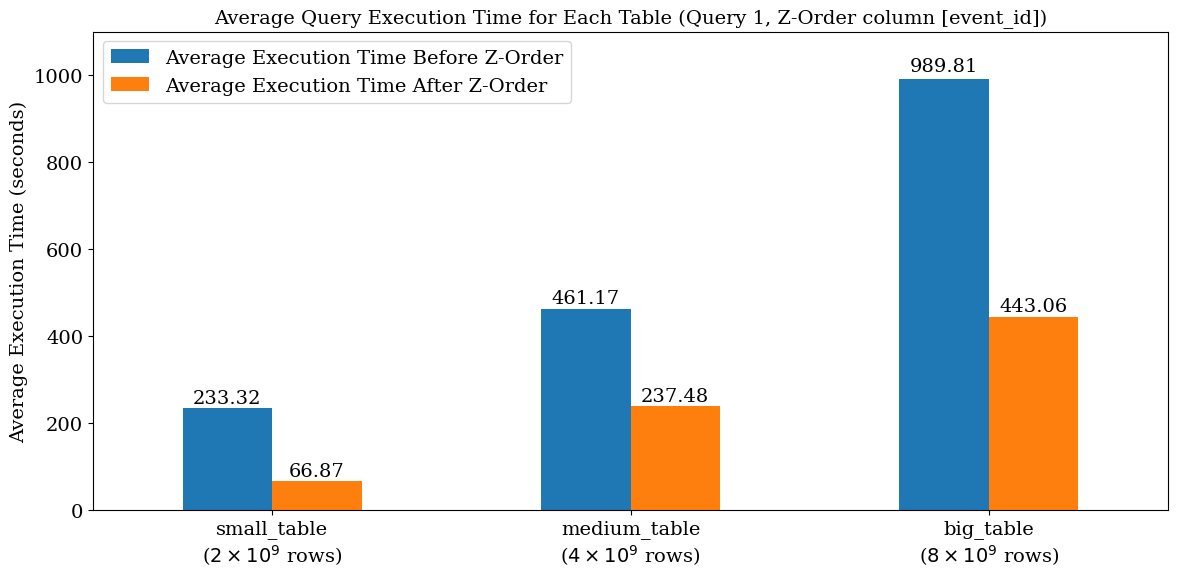

In [30]:
plot_comparison(average_times_part1_before, average_times_part1_after, "[event_id]")

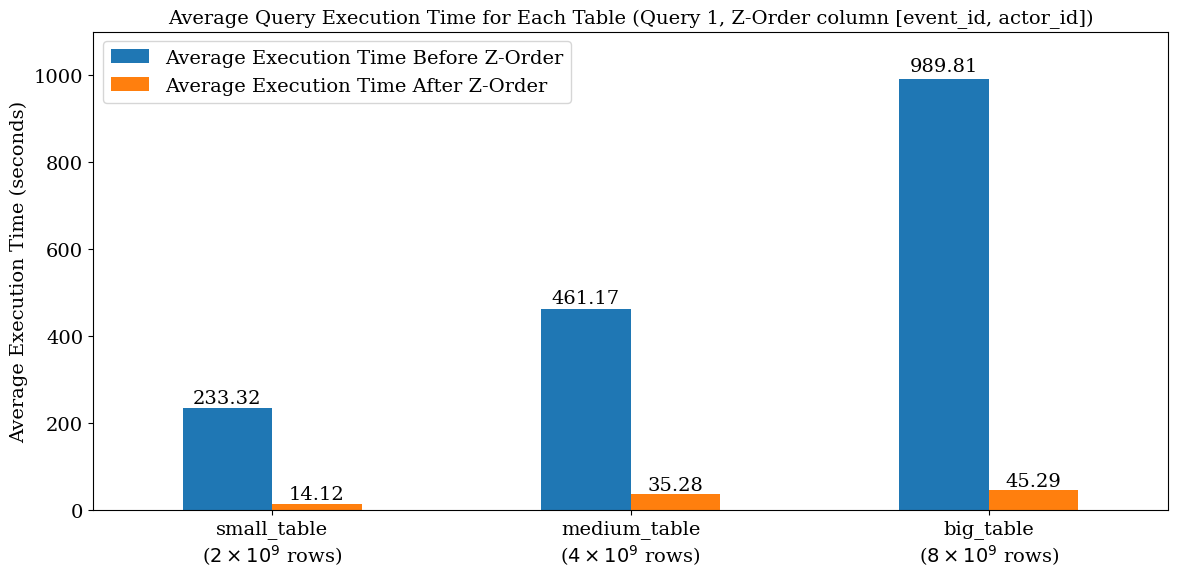

In [31]:
plot_comparison(average_times_part2_before, average_times_part2_after, "[event_id, actor_id]")

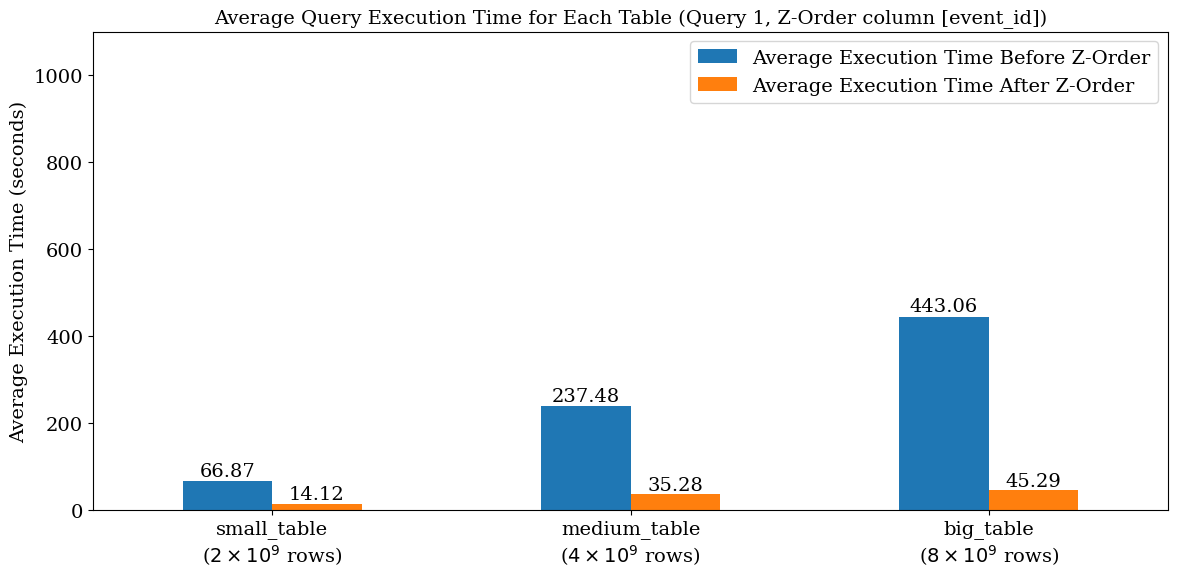

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

average_times_part1_before = {
    'small_table\n($2\\times10^9$ rows)': 66.869337,
    'medium_table\n($4\\times10^9$ rows)': 237.478777,
    'big_table\n($8\\times10^9$ rows)': 443.057015
}

average_times_part1_after = {
    'small_table\n($2\\times10^9$ rows)': 14.115593,
    'medium_table\n($4\\times10^9$ rows)': 35.281418,
    'big_table\n($8\\times10^9$ rows)': 45.288971
}

def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Z-Order"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Z-Order"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query 1, Z-Order column {query_num})')
    plt.xticks(rotation=0)
    
    # Set y-axis limit to 500
    plt.ylim(0, 1100)

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01),  # Center and slightly above the bar
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'zorder_table_performance_{query_num}.png', dpi=500)
    plt.show()

plot_comparison(average_times_part1_before, average_times_part1_after, "[event_id]")
